In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import seaborn as sns
import numpy as np
import glob
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.externals.joblib import Memory
from sklearn.metrics import classification_report
memory = Memory(cachedir='/tmp', verbose=0)
#@memory.cache above any def fxn.

%matplotlib inline
plt.style.use('ggplot')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

%load_ext autotime

In [2]:
os.chdir('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling') #use to change working directory
wd= os.getcwd() #'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling'


final_pt_df2 = pd.read_csv(Path(wd + '/data/raw/csv/01102018_final_pt_df2_v.csv') , index_col=0) #only for patients with minimum vitals
patients= list(final_pt_df2['subject_id'].unique())
hadm_id= list(final_pt_df2['hadm_id'].unique())
icustay_id= list(final_pt_df2['icustay_id'].unique())
icustay_id= [int(x) for x in icustay_id]

time: 117 ms


In [3]:
preImp= pd.read_csv("/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/data/processed/22112018_worstdf2_preImp.csv")
preImp= pd.merge(preImp, final_pt_df2[['icustay_id','final_bin','subject_id']])

time: 74.6 ms


In [4]:
#'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/models/imputation/training_worst%d.txt'

date= '14112018'
os.chdir(r'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/models/imputation/')
allFiles = glob.glob(os.getcwd() + "/{}**.csv".format("training_worst"))
allFiles

['/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/models/imputation/training_worst9.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/models/imputation/training_worst8.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/models/imputation/training_worst20.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/models/imputation/training_worst18.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/models/imputation/training_worst19.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/models/imputation/training_worst17.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/models/imputation/training_worst16.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/models/imputation/training_worst14.csv',
 '/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/models/imputation/training_worst15.csv',
 '/Users/geickelb1/Documents/GitHub/mim

time: 6.03 ms


In [6]:
#making a concatenated dataframe of all imputed 
df_list=[]
for element in allFiles:
    df_list.append(element.split('training_'.format(date))[1].split('.csv')[0]) #making an list of all my dataframes in order they appear in file
#print(sorted(df_list)) 
# dfs = {}
i=0

imputeCat_df= pd.read_csv(allFiles[0])#, index_col=0)
for name in df_list[1:]:
    imputeCat_df= pd.concat([imputeCat_df, pd.read_csv(allFiles[i])])
    #dfs[name] = pd.read_csv(allFiles[i],  index_col=0)
    i+=1

#get rid of an unnamed column
imputeCat_df= imputeCat_df.iloc[:,1:]

time: 2.17 s


In [7]:
imputeCat_df

,icustay_id,bandsNum,bilirubin,bun,chloride,creatinine,daily_sofa,dobutamine,dopamine,epinephrine,...,minCalcium,minSodium,minWBC,ethnicity,gender,leukocyte,nitrite,vent_recieved,subject_id,final_bin
0,200012,11.0,0.5,11,104,1.7,1,False,False,False,...,0.92,135,4.9,asian,F,Neg/Not_tested,Neg/Not_tested,None,28448,C_neg/A_partial
1,200014,1.0,1.1,24,114,0.8,2,False,False,False,...,1.13,138,10.7,unknown/other,M,Neg/Not_tested,Neg/Not_tested,Mech,9514,C_neg/A_partial
2,200030,2.0,14.5,28,111,1.0,4,True,False,False,...,1.15,138,12.5,black,M,Neg/Not_tested,Neg/Not_tested,Oxygen,14987,C_pos/A_full
3,200036,3.0,3.5,31,110,1.0,1,False,False,False,...,1.14,136,4.3,white/nonhispanic,M,Neg/Not_tested,Neg/Not_tested,Oxygen,9960,C_neg/A_partial
4,200055,1.0,0.3,40,100,8.9,8,False,False,False,...,1.11,137,5.7,black,F,Neg/Not_tested,Neg/Not_tested,None,25225,C_neg/A_partial
5,200063,2.0,0.8,54,108,2.3,6,False,False,False,...,1.00,129,7.5,unknown/other,M,Neg/Not_tested,Neg/Not_tested,Mech,99052,C_neg/A_partial
6,200075,4.0,3.1,9,110,0.6,4,False,False,False,...,1.22,135,10.1,white/nonhispanic,F,Neg/Not_tested,Neg/Not_tested,None,67800,C_neg/A_partial
7,200091,1.0,3.5,30,113,1.0,5,False,False,False,...,1.13,141,5.2,unknown/other,M,Neg/Not_tested,Neg/Not_tested,Mech,31854,C_neg/A_partial
8,200116,6.0,0.8,31,107,1.4,1,False,True,False,...,1.19,139,6.1,white/nonhispanic,M,Neg/Not_tested,Neg/Not_tested,None,61654,C_neg/A_partial
9,200136,1.0,0.9,32,104,1.2,3,False,False,False,...,1.00,137,6.2,unknown/other,M,Neg/Not_tested,Neg/Not_tested,Oxygen,6338,C_neg/A_partial


time: 121 ms


In [7]:
#checking pt #'s

# print(len(patients), len(icustay_id))

# print(5446/7778)
print(preImp['icustay_id'].nunique(), preImp['subject_id'].nunique())
print(imputeCat_df['icustay_id'].nunique(), imputeCat_df['subject_id'].nunique()) #good the test set partitioning worked

7778 6994
5446 5025
time: 7.5 ms


# aggregation

In [8]:
imputeMean_df= imputeCat_df.groupby("icustay_id").mean()

time: 71.7 ms


In [9]:
#the aggregation dropped some columns (categorical), so we will add them back in based on the first imputed file (since they will all be the same)
print(len(list(imputeCat_df)),len(list(imputeMean_df)))
print(set(imputeCat_df)-set(imputeMean_df))

firstImpute_temp= pd.read_csv(allFiles[0])#, index_col=0)
missing_list= list(set(imputeCat_df)-set(imputeMean_df))
imputeMean_df= pd.merge(imputeMean_df.reset_index(), firstImpute_temp[missing_list], left_on='icustay_id', right_on='icustay_id')
del(missing_list, firstImpute_temp)

48 41
{'final_bin', 'gender', 'leukocyte', 'vent_recieved', 'ethnicity', 'nitrite', 'icustay_id'}
time: 54 ms


In [10]:
list(set(imputeCat_df)-set(imputeMean_df))
print(len(list(imputeMean_df)), len(list(imputeCat_df))) #good, both have same # of columns

48 48
time: 1.75 ms


In [11]:
#impute range
imputeCat_df.groupby("icustay_id").agg(lambda x: max(x)-min(x))

,bandsNum,bilirubin,bun,chloride,creatinine,daily_sofa,dobutamine,dopamine,epinephrine,first_admit_age,...,platelet,spo2,sysbp,maxCalcium,maxSodium,maxWBC,minCalcium,minSodium,minWBC,subject_id
icustay_id,,,,,,,,,,,,,,,,,,,,,
200012,0.0,1.4,14,18,5.1,0,False,False,False,0.0,...,0,0,0,0.36,17,0.0,0.30,10,0.0,0
200014,29.0,18.3,0,0,0.0,0,False,False,False,0.0,...,0,0,0,0.00,0,0.0,0.00,0,0.0,0
200030,26.0,0.0,0,0,0.0,0,False,False,False,0.0,...,0,0,0,0.00,0,0.0,0.00,0,0.0,0
200036,26.0,3.6,0,0,0.0,0,False,False,False,0.0,...,0,0,0,0.29,0,0.0,0.25,0,0.0,0
200055,23.0,0.0,0,0,0.0,0,False,False,False,0.0,...,0,0,0,0.00,0,0.0,0.00,0,0.0,0
200063,37.0,0.0,0,0,0.0,0,False,False,False,0.0,...,0,0,0,0.00,0,0.0,0.00,0,0.0,0
200075,16.0,0.0,0,0,0.0,0,False,False,False,0.0,...,0,0,0,0.31,0,0.0,0.38,0,0.0,0
200091,46.0,0.0,0,0,0.0,0,False,False,False,0.0,...,0,0,0,0.00,0,0.0,0.00,0,0.0,0
200116,23.0,0.0,0,0,0.0,9,False,False,False,0.0,...,0,0,0,0.00,0,0.0,0.00,0,0.0,0


time: 6.22 s


In [12]:
preImp['bands'].describe()

count    1118.000000
mean       10.337835
std        10.662087
min         1.000000
25%         3.000000
50%         6.000000
75%        14.000000
max        73.000000
Name: bands, dtype: float64

time: 8.36 ms


# QC: 
* how well did imputation perform?
* is averaging the imputed values the best option?


### bands

In [241]:
#before imputation
preImp['bands'].describe()

count    1118.000000
mean       10.337835
std        10.662087
min         1.000000
25%         3.000000
50%         6.000000
75%        14.000000
max        73.000000
Name: bands, dtype: float64

time: 8.67 ms


In [242]:
#after imputation
imputeCat_df['bandsNum'].describe() #5446 rows. so all 20 should have ~100k

count    108920.000000
mean          8.382933
std           8.823242
min           1.000000
25%           2.000000
50%           5.000000
75%          12.000000
max          71.000000
Name: bandsNum, dtype: float64

time: 27.2 ms


In [243]:
#impute mean aggregate
imputeMean_df['bandsNum'].describe()

count    5446.000000
mean        8.382933
std         5.326027
min         1.000000
25%         5.350000
50%         7.200000
75%        10.026250
max        71.000000
Name: bandsNum, dtype: float64

time: 11.1 ms


In [244]:
preImp['bands'].describe()- imputeCat_df['bandsNum'].describe() 
#overall the difference between the distributions isn't very large. the mean went down by 2.

count   -107802.000000
mean          1.954902
std           1.838845
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           2.000000
dtype: float64

time: 23.4 ms


#### what happens if we groupby outcome and look at distribution?

                 count       mean        std  min  25%  50%   75%   max
final_bin                                                              
C_neg/A_partial  583.0   7.942367   8.683094  1.0  2.0  5.0  11.0  73.0
C_pos/A_full     535.0  12.948224  11.938447  1.0  4.0  9.0  18.0  71.0
final_bin
C_neg/A_partial    AxesSubplot(0.125,0.125;0.775x0.755)
C_pos/A_full       AxesSubplot(0.125,0.125;0.775x0.755)
Name: bands, dtype: object


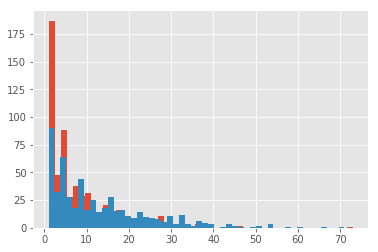

time: 466 ms


In [245]:
#before imputation
print(preImp.groupby("final_bin")['bands'].describe())
print(preImp.groupby("final_bin")['bands'].hist(bins=50))

                   count       mean        std  min  25%  50%   75%   max
final_bin                                                                
C_neg/A_partial  81020.0   7.612752   7.957541  1.0  2.0  5.0  11.0  71.0
C_pos/A_full     27900.0  10.619495  10.644921  1.0  3.0  7.0  15.0  71.0
final_bin
C_neg/A_partial    AxesSubplot(0.125,0.125;0.775x0.755)
C_pos/A_full       AxesSubplot(0.125,0.125;0.775x0.755)
Name: bandsNum, dtype: object


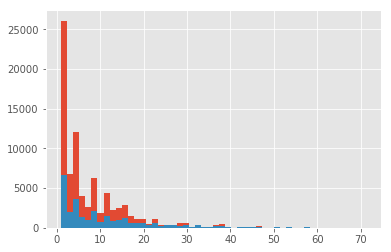

time: 431 ms


In [246]:
#after imputation
print(imputeCat_df.groupby("final_bin")['bandsNum'].describe())
print(imputeCat_df.groupby("final_bin")['bandsNum'].hist(bins=50))

                  count       mean       std  min     25%  50%    75%   max
final_bin                                                                  
C_neg/A_partial  4051.0   7.612752  3.861905  1.0  5.2025  6.9   9.25  47.0
C_pos/A_full     1395.0  10.619495  7.793606  1.0  6.0000  8.6  12.97  71.0
final_bin
C_neg/A_partial    AxesSubplot(0.125,0.125;0.775x0.755)
C_pos/A_full       AxesSubplot(0.125,0.125;0.775x0.755)
Name: bandsNum, dtype: object


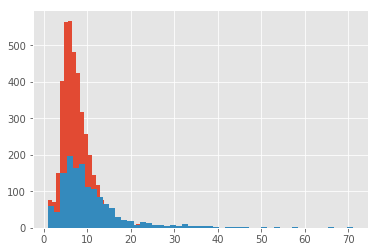

time: 964 ms


In [247]:
#impute mean aggregate
print(imputeMean_df.groupby("final_bin")['bandsNum'].describe())
print(imputeMean_df.groupby("final_bin")['bandsNum'].hist(bins=50))

### so this is noteworthy, the distribution did shift from being left sided to centered. is this an issue?

### overall,it appears the imputation went pretty well.
* the positive mean went up about 30%, while the sd rose ~15%. overall it doesn't look like the values deviated very far.
* the max value 
* the c_neg/A_partial imputation remained extremely stable. 
* pooling the means of imputation does however shift the sidedness of the distribution from left sided to gaussian. 

In [248]:
imputeMean_df.max()

icustay_id                    299995
bandsNum                          71
bilirubin                       50.7
bun                              229
chloride                         140
creatinine                      33.2
daily_sofa                        22
dobutamine                      True
dopamine                        True
epinephrine                     True
first_admit_age                   90
glucose                          997
heartrate                        224
inr                             26.8
lactate                         28.8
norepinephrine                  True
pco2                             143
phenylephrine                   True
potassium                       26.5
ptt                              150
resprate                          69
rrt                             True
temperature                  42.1111
vasopressin                     True
weight                           575
bicarbonate                       50
diasbp                           100
h

time: 90.9 ms


# model preparation 

In [26]:
### useful example, may need to look back upon after evaluating model performance

time: 593 µs


### feature rescaling

When your data is comprised of attributes with varying scales, many machine learning algorithms can benefit from rescaling the attributes to all have the same scale.

Often this is referred to as normalization and attributes are often rescaled into the range between 0 and 1. This is useful for optimization algorithms in used in the core of machine learning algorithms like gradient descent. It is also useful for algorithms that weight inputs like regression and neural networks and algorithms that use distance measures like K-Nearest Neighbors.

In [ ]:
#Example: Rescale data (between 0 and 1)
import pandas
import scipy
import numpy
from sklearn.preprocessing import MinMaxScaler
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)
array = dataframe.values
# separate array into input and output components
X = array[:,0:8]
Y = array[:,8]
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = scaler.fit_transform(X)
# summarize transformed data
numpy.set_printoptions(precision=3)
print(rescaledX[0:5,:])

### feature standardization
Standardization is a useful technique to transform attributes with a Gaussian distribution and differing means and standard deviations to a standard Gaussian distribution with a mean of 0 and a standard deviation of 1.

It is most suitable for techniques that assume a Gaussian distribution in the input variables and work better with rescaled data, such as linear regression, logistic regression and linear discriminate analysis.



In [200]:
#Example: Standardize data (0 mean, 1 stdev)
from sklearn.preprocessing import StandardScaler
import pandas
import numpy
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)
array = dataframe.values
# separate array into input and output components
X = array[:,0:8]
Y = array[:,8]
scaler = StandardScaler().fit(X)
rescaledX = scaler.transform(X)
# summarize transformed data
numpy.set_printoptions(precision=3)
#print(scaler)
print(rescaledX[0:5,:])

StandardScaler(copy=True, with_mean=True, with_std=True)
[[ 0.64   0.848  0.15   0.907 -0.693  0.204  0.468  1.426]
 [-0.845 -1.123 -0.161  0.531 -0.693 -0.684 -0.365 -0.191]
 [ 1.234  1.944 -0.264 -1.288 -0.693 -1.103  0.604 -0.106]
 [-0.845 -0.998 -0.161  0.155  0.123 -0.494 -0.921 -1.042]
 [-1.142  0.504 -1.505  0.907  0.766  1.41   5.485 -0.02 ]]
time: 83.9 ms


### Binarize Data (Make Binary)
You can transform your data using a binary threshold. All values above the threshold are marked 1 and all equal to or below are marked as 0.

This is called binarizing your data or threshold your data. It can be useful when you have probabilities that you want to make crisp values. It is also useful when feature engineering and you want to add new features that indicate something meaningful.

You can create new binary attributes in Python using scikit-learn with the Binarizer class.

In [148]:
# binarization
from sklearn.preprocessing import Binarizer
import pandas
import numpy
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)
array = dataframe.values
# separate array into input and output components
X = array[:,0:8]
Y = array[:,8]
binarizer = Binarizer(threshold=0.0).fit(X)
binaryX = binarizer.transform(X)
# summarize transformed data
numpy.set_printoptions(precision=3)
print(binaryX[0:5,:])

[[1. 1. 1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 0. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1.]]
time: 197 ms


### first seperate target from data.

In [30]:
df= imputeMean_df.copy()

time: 2.24 ms


In [31]:
# y= df.pop('final_bin').values
# len(list(df))

time: 616 µs


In [32]:
cols_to_transform=['rrt', 'phenylephrine', 'norepinephrine', 'vasopressin', 'dobutamine', 'dopamine', 'epinephrine', 'leukocyte', 'vent_recieved', 'ethnicity','nitrite', 'gender']

list(df)

['icustay_id',
 'bandsNum',
 'bilirubin',
 'bun',
 'chloride',
 'creatinine',
 'daily_sofa',
 'dobutamine',
 'dopamine',
 'epinephrine',
 'first_admit_age',
 'glucose',
 'heartrate',
 'inr',
 'lactate',
 'norepinephrine',
 'pco2',
 'phenylephrine',
 'potassium',
 'ptt',
 'resprate',
 'rrt',
 'temperature',
 'vasopressin',
 'weight',
 'bicarbonate',
 'diasbp',
 'hemoglobin',
 'meanartpress',
 'mingcs',
 'pao2fio2Ratio',
 'ph',
 'platelet',
 'spo2',
 'sysbp',
 'maxCalcium',
 'maxSodium',
 'maxWBC',
 'minCalcium',
 'minSodium',
 'minWBC',
 'subject_id',
 'final_bin',
 'gender',
 'leukocyte',
 'ethnicity',
 'vent_recieved',
 'nitrite']

time: 3.74 ms


In [325]:
cols_to_transform=['rrt', 'phenylephrine', 'norepinephrine', 'vasopressin', 'dobutamine', 'dopamine', 'epinephrine', 'leukocyte', 'vent_recieved', 'ethnicity','nitrite', 'gender']

df_with_dummies = pd.get_dummies(df, columns = cols_to_transform )

df_with_dummies

,icustay_id,bandsNum,bilirubin,bun,chloride,creatinine,daily_sofa,first_admit_age,glucose,heartrate,...,vent_recieved_Oxygen,ethnicity_asian,ethnicity_black,ethnicity_hispanic,ethnicity_unknown/other,ethnicity_white/nonhispanic,nitrite_Neg/Not_tested,nitrite_pos,gender_F,gender_M
0,200014,7.740,0.980,24.0,114.0,0.8,2.00,84.73,115.0,91.0,...,0,0,0,0,1,0,1,0,0,1
1,200030,8.900,14.500,28.0,111.0,1.0,4.00,54.19,270.0,130.0,...,1,0,1,0,0,0,1,0,0,1
2,200033,5.350,0.560,16.0,108.0,0.7,1.00,67.14,326.0,126.0,...,0,0,0,0,0,1,1,0,0,1
3,200036,9.800,1.095,31.0,110.0,1.0,1.00,74.93,381.0,130.0,...,1,0,0,0,0,1,1,0,0,1
4,200055,9.900,0.300,40.0,100.0,8.9,8.00,23.73,201.0,108.0,...,0,0,1,0,0,0,1,0,1,0
5,200059,13.380,0.700,50.0,109.0,1.5,6.00,78.90,206.0,128.0,...,0,0,0,0,0,1,1,0,1,0
6,200061,7.900,5.900,15.0,106.0,0.9,3.00,45.75,292.0,106.0,...,1,0,0,0,1,0,1,0,0,1
7,200075,10.350,3.100,9.0,110.0,0.6,4.00,83.64,107.0,106.0,...,0,0,0,0,0,1,1,0,1,0
8,200091,8.150,3.500,30.0,113.0,1.0,5.00,69.72,199.0,95.0,...,0,0,0,0,1,0,1,0,0,1
9,200108,6.600,0.335,28.0,105.0,0.8,2.00,73.82,424.0,137.0,...,0,0,0,0,0,1,1,0,1,0


time: 77.9 ms


### Scikit-Learn Gotcha — Must have 2D data
Most Scikit-Learn estimators require that data be strictly 2-dimensional. If we select the column above as train['HouseStyle'], technically, a Pandas Series is created which is a single dimension of data. We can force Pandas to create a one-column DataFrame, by passing a single-item list to the brackets like this:

In [34]:
imputeMean_df.ndim #2 dimensions, good.

imputeMean_train= imputeMean_df[['leukocyte']].copy()
#imputeMean_train= imputeMean_df.copy()

time: 2.63 ms


In [36]:
imputeMean_train.head()

,leukocyte
0,Neg/Not_tested
1,Neg/Not_tested
2,Neg/Not_tested
3,Neg/Not_tested
4,Neg/Not_tested


time: 4.97 ms


###  Encode factors/categories to numbers

Another possibility to convert categorical features to features that can be used with scikit-learn estimators is to use a one-of-K, also known as one-hot or dummy encoding.

3 step process:

Import, Instantiate, Fit — The three-step process for each estimator
The Scikit-Learn API is consistent for all estimators and uses a three-step process to fit (train) the data.

Import the estimator we want from the module it’s located in
Instantiate the estimator, possibly changing its defaults
Fit the estimator to the data. Possibly transform the data to its new space if need be.

Below, we import OneHotEncoder, instantiate it and ensure that we get a dense (and not sparse) array returned, and then encode our single column with the fit_transform method.

#### below is code i've sense found a different way to do, kept here as a reference 1/7/18:

In [37]:
# #for strings we can use pd.get_dummies() rather than onehotencoder below:

# cols_to_transform=['rrt', 'phenylephrine', 'norepinephrine', 'vasopressin', 'dobutamine', 'dopamine', 'epinephrine', 'leukocyte', 'vent_recieved', 'ethnicity','nitrite', 'gender']

# df_with_dummies = pd.get_dummies(df, columns = cols_to_transform )

# df_with_dummies.head()

,icustay_id,bandsNum,bilirubin,bun,chloride,creatinine,daily_sofa,first_admit_age,glucose,heartrate,...,vent_recieved_Oxygen,ethnicity_asian,ethnicity_black,ethnicity_hispanic,ethnicity_unknown/other,ethnicity_white/nonhispanic,nitrite_Neg/Not_tested,nitrite_pos,gender_F,gender_M
0,200014,7.74,0.980,24.0,114.0,0.8,2.0,84.73,115.0,91.0,...,0,0,0,0,1,0,1,0,0,1
1,200030,8.90,14.500,28.0,111.0,1.0,4.0,54.19,270.0,130.0,...,1,0,1,0,0,0,1,0,0,1
2,200033,5.35,0.560,16.0,108.0,0.7,1.0,67.14,326.0,126.0,...,0,0,0,0,0,1,1,0,0,1
3,200036,9.80,1.095,31.0,110.0,1.0,1.0,74.93,381.0,130.0,...,1,0,0,0,0,1,1,0,0,1
4,200055,9.90,0.300,40.0,100.0,8.9,8.0,23.73,201.0,108.0,...,0,0,1,0,0,0,1,0,1,0


time: 32.9 ms


In [38]:
# dftest= df_with_dummies[['vent_recieved_Mech', "vent_recieved_Oxygen",'vent_recieved_None']].as_matrix()
# dftest
# ohe = OneHotEncoder(sparse=False)
# ohe.fit_transform(dftest)
# #ohe.transform([['vent_recieved_Mech', "vent_recieved_Oxygen",'vent_recieved_None']]).toarray()
# #ohe.fit(dftest)
# #imputeMean_transformed

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


NameError: name 'OneHotEncoder' is not defined

time: 11.3 ms


In [202]:
# #encoder test 2:

# dftest= df_with_dummies.as_matrix()
# dftest
# ohe = OneHotEncoder(sparse=False)
# dftest_transformed2= ohe.fit_transform(dftest)

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


time: 247 ms


In [207]:
# dftest_transformed2.shape
# feature_names = ohe.get_feature_names()
# feature_names
# #ohe.get_feature_names()

AttributeError: 'OneHotEncoder' object has no attribute 'get_feature_names'

time: 8.2 ms


In [183]:
# #doesn't work for w/e reason.
# from sklearn.preprocessing import OneHotEncoder
# ohe = OneHotEncoder(sparse=False)
# imputeMean_transformed = ohe.fit_transform(imputeMean_train)
# imputeMean_transformed

ValueError: could not convert string to float: 'Neg/Not_tested'

time: 13.5 ms


# logstic regression

In [14]:
#Step 1. Import the model you want to use
#In sklearn, all machine learning models are implemented as Python classes


time: 23.7 ms


In [40]:
#Step 2. Make an instance of the Model
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()

time: 993 µs


In [41]:
# Step 2.5: make x_train, y_train
df=imputeMean_df.copy()

#seperate y from x's.
y_train= df.pop('final_bin').values
x_train= df.drop(['subject_id'], axis=1)

#for strings we can use pd.get_dummies() rather than onehotencoder below:
cols_to_transform=['rrt', 'phenylephrine', 'norepinephrine', 'vasopressin', 'dobutamine', 'dopamine', 'epinephrine', 'leukocyte', 'vent_recieved', 'ethnicity','nitrite', 'gender']
x_train = pd.get_dummies(x_train, columns = cols_to_transform )


time: 22.5 ms


In [42]:
y_train_dum= pd.get_dummies(y_train, columns = cols_to_transform )

time: 2.62 ms


In [43]:
pd.DataFrame(y_train)[0].value_counts()

C_neg/A_partial    4044
C_pos/A_full       1402
Name: 0, dtype: int64

time: 4.59 ms


In [44]:
final_pt_df2['final_bin'].value_counts()

C_neg/A_partial    5754
C_neg/A_full       5492
C_pos/A_full       2024
C_pos/A_partial    1398
Name: final_bin, dtype: int64

time: 5.36 ms


In [45]:
5754/(5754+2024)

0.7397788634610439

time: 2.12 ms


In [46]:
4044/(1402+4044)

0.7425633492471538

time: 2.13 ms


In [47]:
y_train

array(['C_neg/A_partial', 'C_pos/A_full', 'C_pos/A_full', ...,
       'C_neg/A_partial', 'C_neg/A_partial', 'C_neg/A_partial'],
      dtype=object)

time: 1.95 ms


In [48]:
#Step 3. Training the model on the data, storing the information learned from the data

#Model is learning the relationship between digits (x_train) and labels (y_train)

logisticRegr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

time: 77.7 ms


In [49]:
logisticRegr.score(x_train,y_train)

0.7728608152772677

time: 15.1 ms


In [50]:
y_train_dum['C_pos/A_full']

0       0
1       1
2       1
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      1
14      1
15      1
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      0
25      0
26      1
27      0
28      0
29      0
       ..
5416    0
5417    0
5418    0
5419    0
5420    0
5421    0
5422    1
5423    1
5424    0
5425    0
5426    0
5427    1
5428    0
5429    0
5430    1
5431    0
5432    0
5433    0
5434    0
5435    1
5436    0
5437    0
5438    0
5439    0
5440    0
5441    0
5442    0
5443    0
5444    0
5445    0
Name: C_pos/A_full, Length: 5446, dtype: uint8

time: 4.03 ms


In [56]:
logisticRegr.coef_

array([[ 8.74260165e-07,  8.96130797e-03,  3.42468173e-03,
         8.03925992e-03,  1.62241787e-03, -1.13111049e-03,
         6.46620182e-03,  1.55828568e-03,  5.77678015e-05,
         1.59893840e-02,  1.38227188e-03,  3.41920659e-03,
        -6.67462021e-03, -1.21244653e-03, -2.77954560e-05,
         1.38052625e-02,  2.29258534e-03,  1.69934843e-03,
        -6.73254063e-03, -6.01770830e-03, -1.77541370e-03,
        -9.04443875e-03, -7.25412750e-03, -1.37387345e-03,
        -2.11139180e-04, -3.04568090e-04, -1.29779727e-02,
        -1.34198793e-02, -1.22773356e-04, -3.49212329e-04,
         1.40328524e-02, -9.14804937e-05, -2.47777363e-03,
         5.36941436e-03, -1.43099219e-05, -6.75897427e-06,
         1.31874151e-04, -1.52943047e-04, -8.68184061e-04,
         8.47115165e-04, -1.75604859e-04,  1.54535963e-04,
        -7.25823740e-05,  5.15134779e-05, -1.03720118e-04,
         8.26512218e-05,  2.20436074e-04, -2.41504970e-04,
        -1.13682286e-03,  1.11575396e-03,  6.34074872e-0

time: 3.22 ms


In [49]:
confusion_matrix(logisticRegr.predict(x_train),y_train)


#since we are interested in the prediction of both (ie classifier vs yes/no answer), we should calculate the precision of both neg and pos patients and report each and the average as well. 

array([[3871, 1064],
       [ 173,  338]])

time: 31 ms


In [53]:
pd.DataFrame(y_train).nunique()

0    2
dtype: int64

time: 15.2 ms


In [66]:
#roc_auc_score(logisticRegr.predict(x_train),y_train)
roc_auc_score(logisticRegr.predict(x_train), y_train_dum['C_pos/A_full'])

ValueError: Data is not binary and pos_label is not specified

time: 29.4 ms


In [51]:
#Step 4. Predict labels for new data (new images)

#Uses the information the model learned during the model training process

# Returns a NumPy Array
# Predict for One Observation (image)
logisticRegr.predict(x_test[0].reshape(1,-1))
Predict for Multiple Observations (images) at Once

logisticRegr.predict(x_test[0:10])
Make predictions on entire test data

predictions = logisticRegr.predict(x_test)


SyntaxError: invalid syntax (<ipython-input-51-11abd8a1b820>, line 8)

to_do:
    
    need to go back and use stratify split in python for train/test set split BEFORE imputation. (i might not need to)
    
    
    also, the mean aggregation may be biasing the data. try training 20 skl models in pandas and both:
            average coefficients
            try to implement logic of R's Pool function
    
    
    for later: look into skl ensemble. could also wrap the 20 logistic regression "learners"(models) using the ensemble function. 

# Ensemble (building 20 models and combining them)

https://scikit-learn.org/stable/modules/ensemble.html

In [ ]:
https://scikit-learn.org/stable/modules/ensemble.html

In [84]:
import missingno as msno

time: 30.6 ms


In [ ]:
msno.heatmap(merged_df[missingdata_df], figsize=(20,20))

In [87]:
msno.heatmap(imputeMean_df[imputeMean_df], figsize=(20,20))

ValueError: Must pass DataFrame with boolean values only

time: 43.9 ms


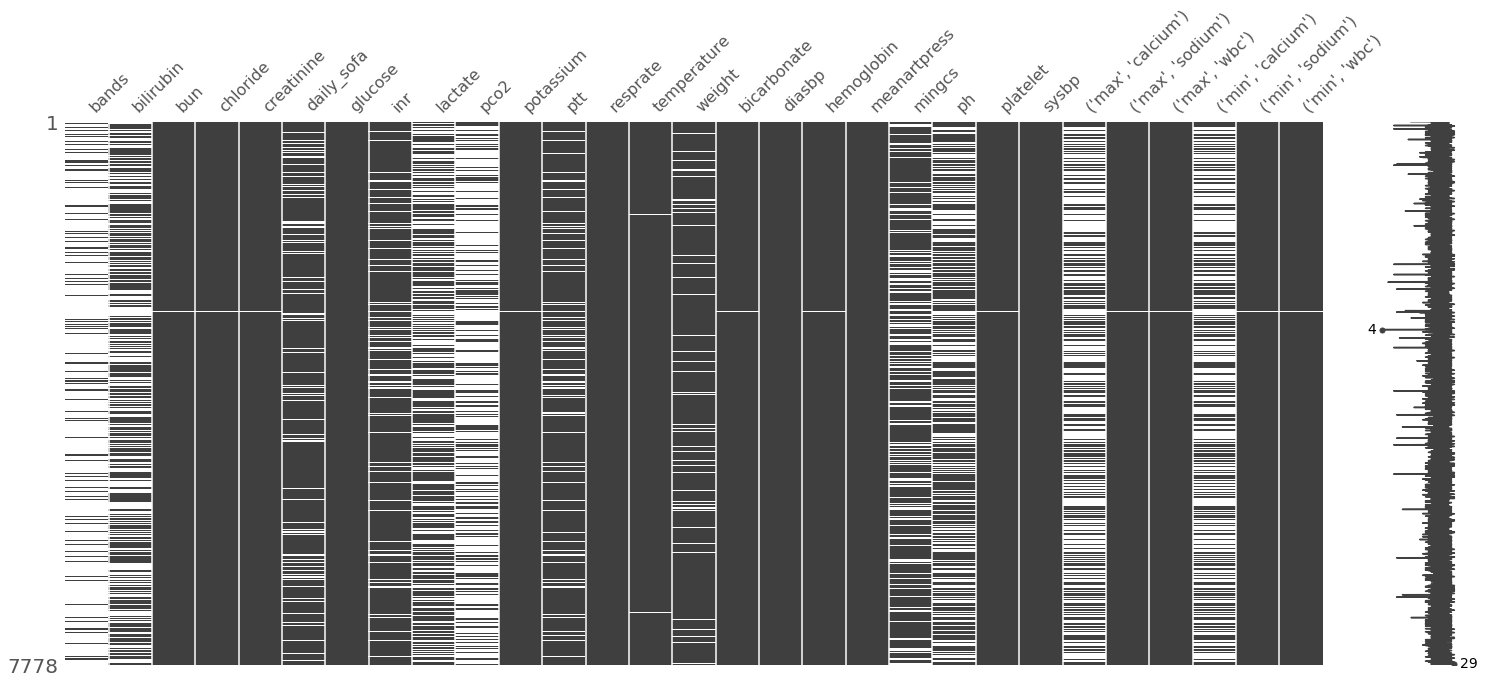

time: 659 ms


In [92]:
#train_df = pd.read_csv('train_2016_v2.csv', parse_dates=["transactiondate"])
#properties_df = pd.read_csv('properties_2016.csv')
#merged_df = pd.merge(train_df,properties_df)
missingdata_df = preImp.columns[preImp.isnull().any()].tolist()
msno.matrix(preImp[missingdata_df])

In [90]:
missingdata_df

['bands',
 'bilirubin',
 'bun',
 'chloride',
 'creatinine',
 'daily_sofa',
 'glucose',
 'inr',
 'lactate',
 'pco2',
 'potassium',
 'ptt',
 'resprate',
 'temperature',
 'weight',
 'bicarbonate',
 'diasbp',
 'hemoglobin',
 'meanartpress',
 'mingcs',
 'ph',
 'platelet',
 'sysbp',
 "('max', 'calcium')",
 "('max', 'sodium')",
 "('max', 'wbc')",
 "('min', 'calcium')",
 "('min', 'sodium')",
 "('min', 'wbc')"]

time: 2.72 ms


In [94]:
preImp

,icustay_id,bands,bilirubin,bun,chloride,creatinine,daily_sofa,dobutamine,dopamine,epinephrine,...,"('min', 'calcium')","('min', 'sodium')","('min', 'wbc')",ethnicity,gender,leukocyte,nitrite,vent_recieved,final_bin,subject_id
0,200012.0,11.0,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,...,NaN,NaN,4.9,asian,F,Neg/Not_tested,Neg/Not_tested,None,C_neg/A_partial,28448
1,200014.0,NaN,NaN,24.0,114.0,0.8,2.0,0.0,0.0,0.0,...,1.13,138.0,10.7,unknown/other,M,Neg/Not_tested,Neg/Not_tested,Mech,C_neg/A_partial,9514
2,200030.0,NaN,14.5,28.0,111.0,1.0,4.0,1.0,0.0,0.0,...,1.15,138.0,12.5,black,M,Neg/Not_tested,Neg/Not_tested,Oxygen,C_pos/A_full,14987
3,200033.0,NaN,NaN,16.0,108.0,0.7,1.0,0.0,0.0,0.0,...,1.03,133.0,6.2,white/nonhispanic,M,Neg/Not_tested,Neg/Not_tested,None,C_pos/A_full,56369
4,200036.0,NaN,NaN,31.0,110.0,1.0,1.0,0.0,0.0,0.0,...,NaN,136.0,4.3,white/nonhispanic,M,Neg/Not_tested,Neg/Not_tested,Oxygen,C_neg/A_partial,9960
5,200055.0,NaN,0.3,40.0,100.0,8.9,8.0,0.0,0.0,0.0,...,1.11,137.0,5.7,black,F,Neg/Not_tested,Neg/Not_tested,None,C_neg/A_partial,25225
6,200059.0,NaN,0.7,50.0,109.0,1.5,6.0,0.0,0.0,0.0,...,1.01,132.0,8.5,white/nonhispanic,F,Neg/Not_tested,Neg/Not_tested,None,C_neg/A_partial,28494
7,200061.0,NaN,5.9,15.0,106.0,0.9,3.0,0.0,0.0,0.0,...,NaN,137.0,11.5,unknown/other,M,Neg/Not_tested,Neg/Not_tested,Oxygen,C_neg/A_partial,74282
8,200063.0,NaN,0.8,54.0,108.0,2.3,6.0,0.0,0.0,0.0,...,1.00,129.0,7.5,unknown/other,M,Neg/Not_tested,Neg/Not_tested,Mech,C_neg/A_partial,99052
9,200075.0,NaN,3.1,9.0,110.0,0.6,4.0,0.0,0.0,0.0,...,NaN,135.0,10.1,white/nonhispanic,F,Neg/Not_tested,Neg/Not_tested,None,C_neg/A_partial,67800


time: 58.3 ms


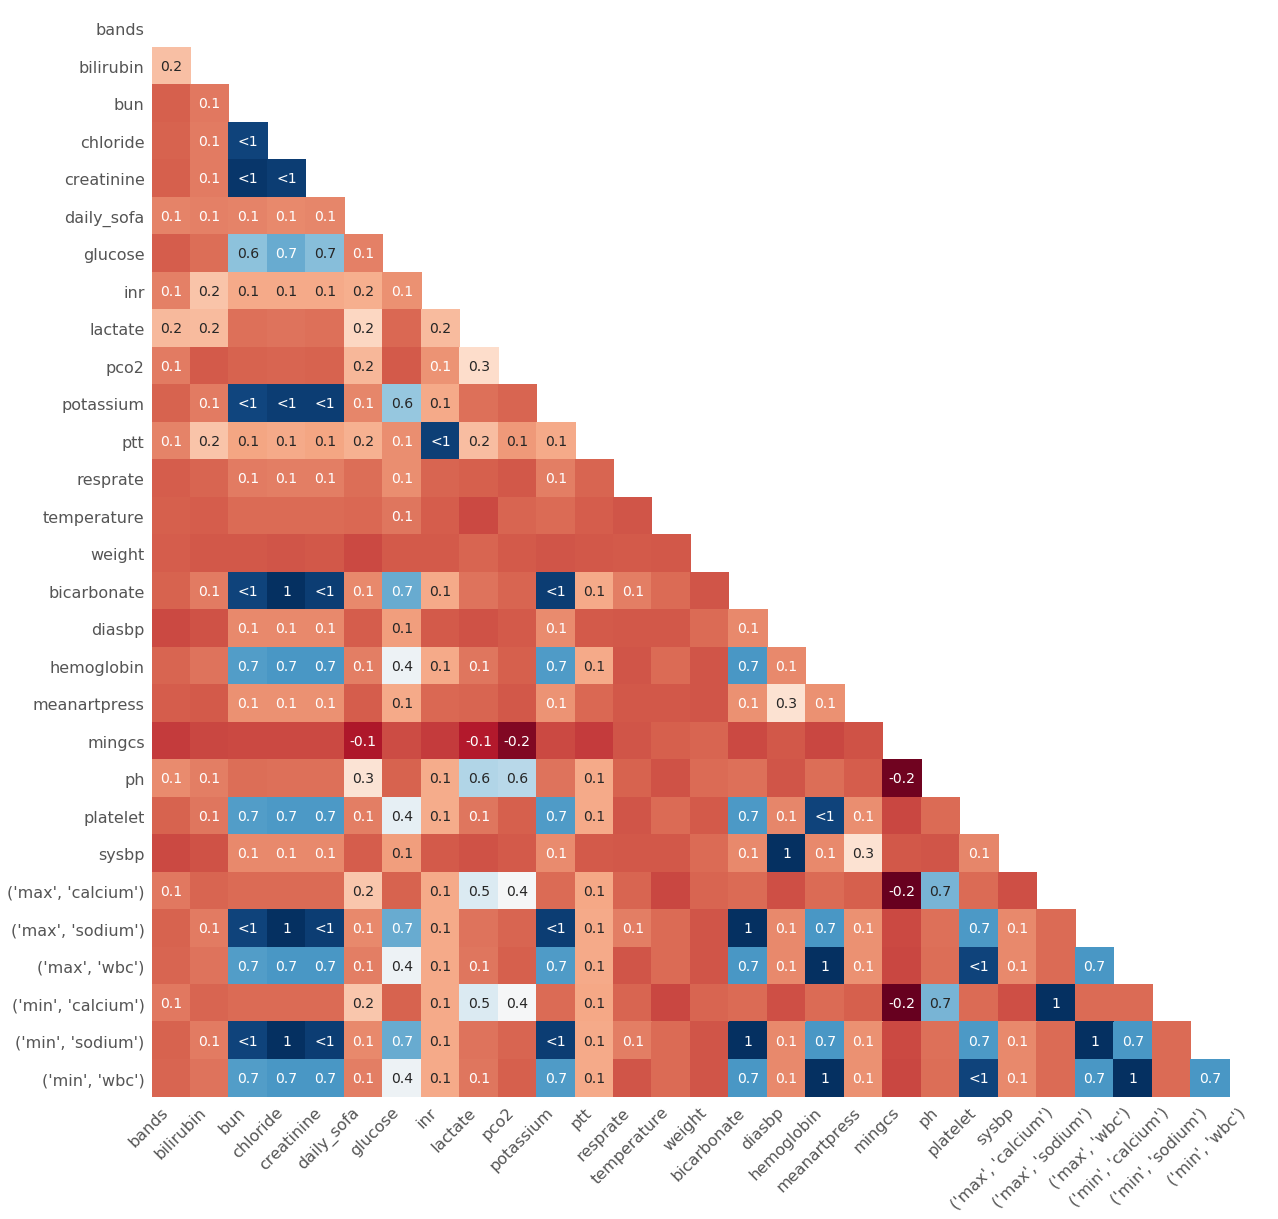

time: 1.56 s


In [93]:
#unclear of what this is

msno.heatmap(preImp[missingdata_df], figsize=(20,20))

MICE in python:
    
Multiple imputation is a process where the missing values are filled multiple times to create “complete” datasets. Multiple imputation has a lot of advantages over traditional single imputation methods. Multiple Imputation by Chained Equations (MICE) is an imputation method that works with the assumption that the missing data are Missing at Random (MAR). Recall that for MAR, the nature of the missing data is related to the observed data but not the missing data. The MICE algorithm works by running multiple regression models and each missing value is modeled conditionally depending on the observed (non-missing) values. A complete explanation of the MICE algorithm can be seen here. fancyimpute.MICE().complete(data matrix) can be used for MICE implementation.

https://medium.com/ibm-data-science-experience/missing-data-conundrum-exploration-and-imputation-techniques-9f40abe0fd87
This article highlights the importance of missing data in data science projects. It reviews exploration techniques and important imputation methods used for handling missing data. The other methods not described are model-based and machine learning based methods. Model-based methods assume a joint distribution of all the missing values in the model and estimate the model parameters describing the observed data. A wildly used model-based imputation method is a Pattern Mixture Model (PMM) trained with expectation-maximization (EM-) algorithm. Machine learning algorithms like eXtreme Gradient Boosting (xgboost) automatically learn the best imputation value for the missing data based on the training loss reduction.

advice on how to pool models in skl.
https://datascience.stackexchange.com/questions/23586/sklearn-aggregating-multiple-fitted-models-into-a-single-model-binary-classifi

In [96]:
from statsmodels import imputation

time: 14 ms


In [98]:
from sklearn.linear_model import LinearRegression
import skmice

imputer = MiceImputer()
X = [[1, 2], [np.nan, 3], [7, 6]]

X, specs = imputer.transform(X, LinearRegression, 10)

print (specs)

ModuleNotFoundError: No module named 'skmice'

time: 73.4 ms


last day before vacation, trying to:

* use ensemble to build multiple models,
* use a function to build many logistic regression models and compare
* test different models
* evaluate model.

# making fxn for regression models

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

time: 59.8 ms


below is the last stuff i did before vacation, todo 1/7/18 (see bottom of notebook):  need to go through this code and:

* first need to evaluate the correlation matrix of variables pre and post imputation
* need to determine variables of most importance in models i build
* need to have a robust evaluation of model performance
* need to try cross validation

In [78]:
###note for future ml code, I can just do df['column'].values to get the skl formatted matrix.

time: 597 µs


In [6]:
def allFileRead(allFileIndex):
    testEnsDf1= pd.read_csv(allFiles[allFileIndex])#, index_col=0)
    testEnsDf1= testEnsDf1.iloc[:,1:] #removing the unknown value column
    
    return(testEnsDf1)

time: 2.57 ms


In [7]:
def preprocessing(testEnsDf1):
    from sklearn.preprocessing import label_binarize
    
    #enter in a dataframe with x's and y.
    X=testEnsDf1.copy()
    
    #YTRUE
    ##seperate target out and convert string values into binary
    classes=['C_neg/A_partial', 'C_pos/A_full']
    y = label_binarize(X["final_bin"].values, classes=classes) #0 = neg, 1 = pos

    #XTRAIN 
    x_features= [c for c in X.columns.values if c not in ["subject_id", "icustay_id", "final_bin"]]
    X= X[x_features]
    
    ##for strings we can use pd.get_dummies() rather than onehotencoder below:
    cols_to_transform=['rrt', 'phenylephrine', 'norepinephrine',
                       'vasopressin', 'dobutamine', 'dopamine',
                       'epinephrine', 'leukocyte', 'vent_recieved',
                       'ethnicity','nitrite', 'gender']
    
    X = pd.get_dummies(X, columns = cols_to_transform )
        
    return(X, np.ravel(y), x_features, classes)



time: 14.7 ms


In [8]:
#ROC plot

def model_roc(y, y_score):
    roc_output= roc_curve(np.ravel(y),y_score)
    plt.figure()
    lw = 2
    plt.plot(roc_output[0], roc_output[1], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score(np.ravel(y), y_score))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    return(plt)

time: 13 ms


In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



time: 30.6 ms


In [13]:
def logitAUC(X, y, labels, classes):
    from sklearn.metrics import roc_curve, auc
    
    classifier= LogisticRegression(class_weight="balanced")

    ##fiting the model to y
    model_fit= classifier.fit(X, y)

    ## y predicted
    y_pred= classifier.predict(X)
    
    ## y score: can either be probability estimates of the positive class
    """
    y_score : array, shape = [n_samples]
        Target scores, can either be probability estimates of the positive class, confidence values, 
        or non-thresholded measure of decisions (as returned by “decision_function” on some classifiers).
    """
    y_score = model_fit.predict_proba(X)[:,1]
    
    ##confusion matrix
    confuse= confusion_matrix(y, y_pred) #y_test, y_pred
    print(confuse)

    ##scoring model based on true positive prediction rate and AUC.
    model_score= classifier.score(X,y)

    print("model fit:\n %s \n" % (model_fit),
          "model score: %s \n" %(model_score),
        "AUC: %s \n" % (roc_auc_score(y, y_score)),
         "Confusion matrix: \n %s" %(confuse),
         "classification_report: ", classification_report(y, y_pred)) 
    #roc plotting fxn
    model_roc(y, y_score)

        # Plot non-normalized confusion matrix
    plot_confusion_matrix(confuse,
                          classes, #output of preprocessing
                          title='Confusion matrix, without normalization')


time: 23.1 ms


##### side tangent: pipeline practice

In [216]:
#pipeline practice
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline


classifier= LogisticRegression(class_weight="balanced")

time: 5.86 ms


ValueError: too many values to unpack (expected 3)

time: 69.5 ms


cv_scores:  [0.73626374 0.72844037 0.76513761 0.73394495 0.74678899 0.76470588
 0.69301471 0.73161765 0.75551471 0.71507353] 
 classification report:              precision    recall  f1-score   support

          0       0.87      0.75      0.81      4051
          1       0.49      0.69      0.57      1395

avg / total       0.78      0.74      0.75      5446
 model score: 0.7370547190598604 
 Accuracy: 0.74 (+/- 0.04) 
 AUC: 0.7848858948053892 
 Confusion matrix: 
 [[3056  995]
 [ 437  958]]


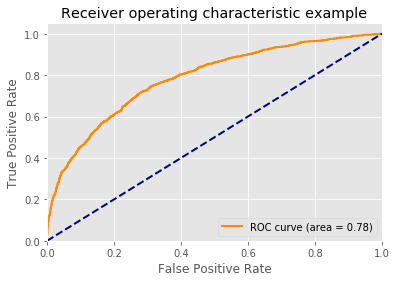

<module 'matplotlib.pyplot' from '/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/matplotlib/pyplot.py'>

time: 15 s


In [12]:
#my cv implementation of logistic regression_ -out of place here but useful reference
# #cv using logistic reg  ##correct
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, cross_validation
import sklearn.cross_validation
from sklearn.model_selection import cross_val_predict

X, y, labels, classes = preprocessing(allFileRead(0))

# setup model
classifier= LogisticRegression(class_weight="balanced")

##initializing model NOTE NO MODEL.FIT WAS USED HERE IN CV METHOD, need to dig into more about why this works as it does.
#model_fit= classifier.fit(X, y)fit

# cross-validation scores
scores = cross_val_score(classifier, X, y, cv=10) #accuracy score across each cv
y_pred = cross_validation.cross_val_predict(classifier, X, y, cv=10)

#HMMMM, I NED TO LOOK INTO Y_PRED, THIS MAY NOT BE KOSHER FOR CV

##confusion matrix
confuse= confusion_matrix(y, y_pred) #which is the correct order?

##scoring model based on true positive prediction rate and AUC.
model_score= metrics.accuracy_score(y, y_pred)
y_score = cross_val_predict(classifier, X, y, cv=5, method='predict_proba')[:,1]
auc_score= roc_auc_score(y, y_score)

print("cv_scores: ", scores,
    "\n classification report:", metrics.classification_report(y, y_pred),
      "model score: %s \n" %(model_score),
    "Accuracy: %0.2f (+/- %0.2f) \n" % (scores.mean(), scores.std() * 2),
    "AUC: %s \n" % (roc_auc_score(y, y_score)),
     "Confusion matrix: \n %s" %(confuse))

model_roc(y, y_score)

In [ ]:
###need to compare to logisticrgressionCV in sklearn. 

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[[3070  421]
 [ 981  974]]
[[3053  416]
 [ 998  979]]
[[3104  432]
 [ 947  963]]
[[3055  430]
 [ 996  965]]
[[3079  434]
 [ 972  961]]


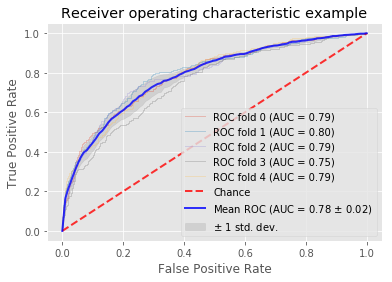

time: 2.92 s


In [224]:
#a different cv implementation of logistic regression_ -out of place here but useful reference
###skl logistic regression auc with cv example (using manual implementation)

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp

cv = StratifiedKFold(n_splits=5)
classifier= LogisticRegression(class_weight="balanced")

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X.as_matrix(), np.ravel(y)):
    probas_ = classifier.fit(X.as_matrix()[train], np.ravel(y)[train]).predict_proba(X.as_matrix()[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    ##
    confuse= confusion_matrix(classifier.predict(X),y)
    print(confuse)
    ##
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#pipeline example

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline

#Define simple model
###############################################################################
C = np.arange(1e-05, 5.5, 0.1)
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}
log_reg = LogisticRegression()

#Simple pre-processing estimators
###############################################################################
std_scale = StandardScaler(with_mean=False, with_std=False)
#std_scale = StandardScaler()

#Defining the CV method: Using the Repeated Stratified K Fold
###############################################################################

n_folds=5
n_repeats=5

rskfold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=2)

#Creating simple pipeline and defining the gridsearch
###############################################################################

log_clf_pipe = Pipeline(steps=[('scale',std_scale), ('clf',log_reg)])


###using gridsearch seems useful but is more complex and is exhaustive. 
log_clf = GridSearchCV(estimator=log_clf_pipe, cv=rskfold,
              scoring=scoring, return_train_score=True,
              param_grid=dict(clf__C=C), refit='Accuracy')

log_clf.fit(X, y)
results = log_clf.cv_results_

print('='*20)
print("best params: " + str(log_clf.best_estimator_))
print("best params: " + str(log_clf.best_params_))
print('best score:', log_clf.best_score_)
print('='*20)


### testing different logistic models (not using cv yet)

             precision    recall  f1-score   support

          0       0.82      0.94      0.87     81020
          1       0.69      0.38      0.49     27900

avg / total       0.78      0.80      0.78    108920

model fit:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 
 model score: 0.798292324641939 
 AUC: 0.795884780871841 
 Confusion matrix: 
 [[76360 17310]
 [ 4660 10590]]


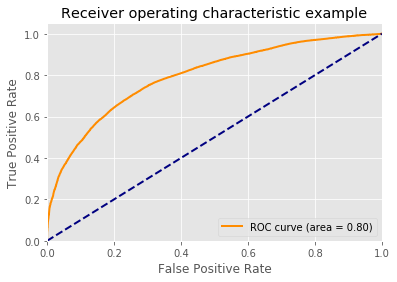

time: 13.2 s


In [305]:
logitAUC(imputeCat_df)

             precision    recall  f1-score   support

          0       0.82      0.94      0.87      4051
          1       0.69      0.38      0.49      1395

avg / total       0.78      0.80      0.78      5446

model fit:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 
 model score: 0.7987513771575468 
 AUC: 0.7976395933921356 
 Confusion matrix: 
 [[3814  859]
 [ 237  536]]


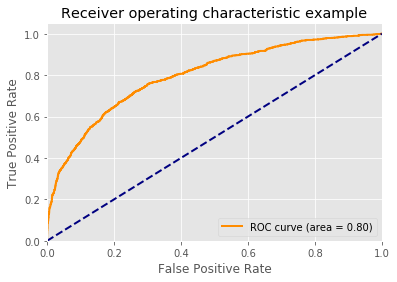

time: 579 ms


In [306]:
logitAUC(imputeMean_df)

[[3084  967]
 [ 420  975]]
model fit:
 LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) 
 model score: 0.7453176643408006 
 AUC: 0.7986823909136999 
 Confusion matrix: 
 [[3084  967]
 [ 420  975]] classification_report:               precision    recall  f1-score   support

          0       0.88      0.76      0.82      4051
          1       0.50      0.70      0.58      1395

avg / total       0.78      0.75      0.76      5446



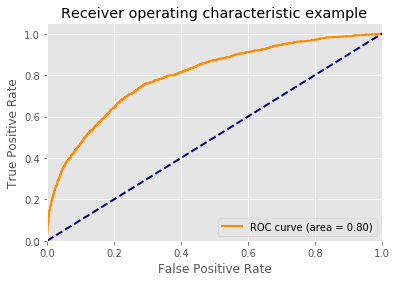

Confusion matrix, without normalization
[[3084  967]
 [ 420  975]]


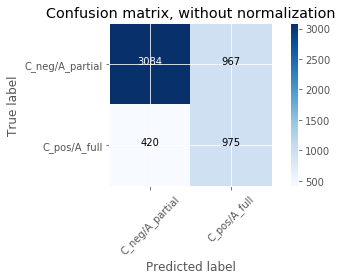

time: 1.03 s


In [14]:
X,y,labels, classes= preprocessing(allFileRead(0))
logitAUC(X,y,labels,classes)

looking at the precision and recall, recall is the # of truepos/ truepos+false neg, or the number of htings it got right over number of things got right + number of things i predicted wrong. the recall is 0.38 for my infection positive prediction, sugesting that my model is struggling the most in predicting those patients that have an infection. 

#### #feature standardization

             precision    recall  f1-score   support

          0       0.88      0.76      0.82      4051
          1       0.50      0.70      0.58      1395

avg / total       0.78      0.75      0.76      5446

model fit:
 LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) 
 model score: 0.7455012853470437 
 AUC: 0.7990561204853177 
 Confusion matrix: 
 [[3084  419]
 [ 967  976]]


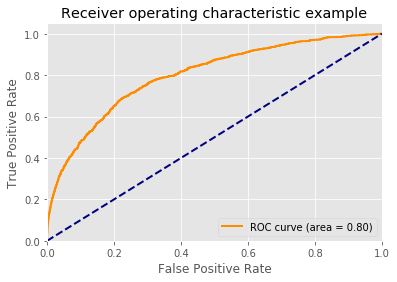

time: 289 ms


In [215]:
from sklearn.preprocessing import StandardScaler
#feature standardization
zero_train, zero_true, labels= preprocessing(allFileRead(0))
scaler = StandardScaler().fit(zero_train)
rescaledX = scaler.transform(zero_train)

rescaledX_df=pd.DataFrame(rescaledX)
rescaledX_df.columns= list(zero_train)
logitAUC(rescaledX_df,zero_true,labels)

###feature standardization doesn't appear to change the auc at all.

## tree classifiers

Feature ranking:
1. feature 15 temperature (0.037598)
2. feature 5 daily_sofa (0.031829)
3. feature 26 sysbp (0.028835)
4. feature 8 heartrate (0.028079)
5. feature 14 resprate (0.027591)
6. feature 17 bicarbonate (0.025460)
7. feature 37 norepinephrine_False (0.025341)
8. feature 29 maxWBC (0.025001)
9. feature 20 meanartpress (0.024964)
10. feature 38 norepinephrine_True (0.024933)
11. feature 2 bun (0.024722)
12. feature 32 minWBC (0.024686)
13. feature 21 mingcs (0.024640)
14. feature 23 ph (0.024421)
15. feature 25 spo2 (0.024036)
16. feature 10 lactate (0.022747)
17. feature 1 bilirubin (0.022003)
18. feature 9 inr (0.021998)
19. feature 3 chloride (0.021985)
20. feature 19 hemoglobin (0.021872)
21. feature 30 minCalcium (0.021736)
22. feature 28 maxSodium (0.021677)
23. feature 0 bandsNum (0.021645)
24. feature 11 pco2 (0.021245)
25. feature 31 minSodium (0.021183)
26. feature 12 potassium (0.021167)
27. feature 16 weight (0.021006)
28. feature 18 diasbp (0.020953)
29. feature 2

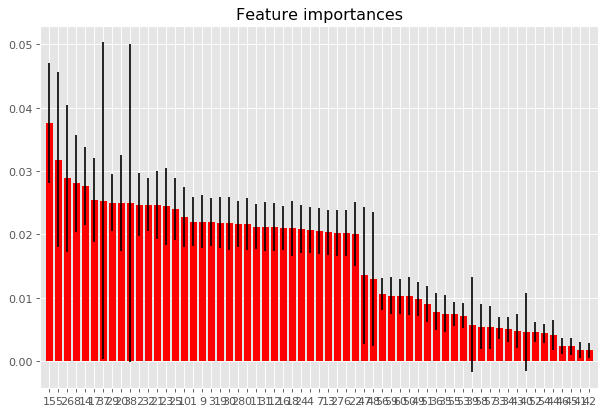

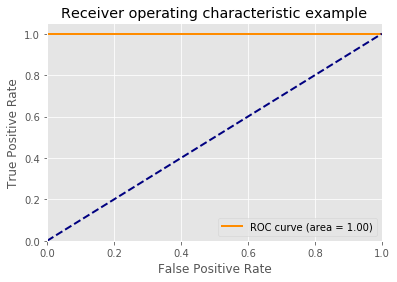

<module 'matplotlib.pyplot' from '/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/matplotlib/pyplot.py'>

time: 4.32 s


In [103]:
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

X, y, labels = preprocessing(allFileRead(0))
    
    # Build a forest and compute the feature importances
classifier = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)
#         ##initializing model
model_fit= classifier.fit(X, np.ravel(y))
model_fit

#         ##initializing model
# model_fit= classifier.fit(x_train, np.ravel(y_true))
importances = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], labels[indices[f]],  importances[indices[f]]))

    
    # Plot the feature importances of the forest
#plt.figure()
plt.figure(figsize=(9, 6), dpi= 80, facecolor='w')
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

#auc
y_score = classifier.fit(X, y).predict_proba(X)[:,1]

model_roc(y, y_score)



In [79]:
indices

array([ 5, 37, 38, 26,  8, 15, 17, 22, 48, 23, 47, 20, 25, 29, 21, 40, 10,
       14,  2, 30,  9,  4, 18, 49, 28, 36,  0,  3, 33, 55, 52, 13, 12, 11,
       53, 54,  7, 32,  6, 56, 57, 58,  1, 51, 16, 50, 46, 19, 45, 44, 43,
       42, 24, 41, 39, 27, 35, 34, 59, 31, 60])

time: 2.37 ms


Feature ranking:
1. feature 5 daily_sofa (0.164200)
2. feature 37 norepinephrine_False (0.142900)
3. feature 38 norepinephrine_True (0.119700)
4. feature 26 sysbp (0.115200)
5. feature 8 heartrate (0.061300)
6. feature 15 temperature (0.047900)
7. feature 17 bicarbonate (0.043200)
8. feature 22 pao2fio2Ratio (0.040100)
9. feature 48 leukocyte_pos (0.033900)
10. feature 23 ph (0.032800)
11. feature 47 leukocyte_Neg/Not_tested (0.028800)
12. feature 20 meanartpress (0.022300)
13. feature 25 spo2 (0.021900)
14. feature 29 maxWBC (0.019100)
15. feature 21 mingcs (0.018500)
16. feature 40 vasopressin_True (0.016900)
17. feature 10 lactate (0.016600)
18. feature 14 resprate (0.010500)
19. feature 2 bun (0.010000)
20. feature 30 minCalcium (0.009500)
21. feature 9 inr (0.007500)
22. feature 4 creatinine (0.004800)
23. feature 18 diasbp (0.003200)
24. feature 49 vent_recieved_Mech (0.002200)
25. feature 28 maxSodium (0.002200)
26. feature 36 phenylephrine_True (0.001900)
27. feature 0 bandsNum

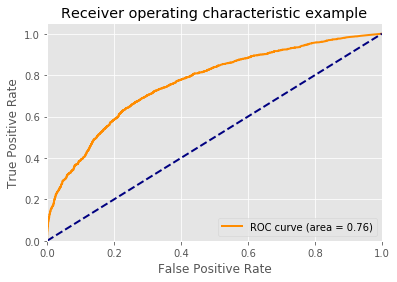

<module 'matplotlib.pyplot' from '/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/matplotlib/pyplot.py'>

time: 626 ms


In [190]:
## random forest
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

X, y, labels = preprocessing(allFileRead(0))
    
# Build a randomforest and compute the feature importances
classifier = RandomForestClassifier(n_estimators=50, max_depth=2,random_state=0)  #is there a ballanced option?
#max_depth:
#random_state=0 :
#n_estimators: 

model_fit=classifier.fit(X, y)
model_fit

importances = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % 
          (f + 1, indices[f],
           labels[indices[f]],
           round(importances[indices[f]],4)))

##confusion matrix
confuse= confusion_matrix(classifier.predict(X),y)

##scoring model based on true positive prediction rate and AUC.
model_score= classifier.score(X,y)
y_score = classifier.fit(X, y).predict_proba(X)[:,1]
auc_score= roc_auc_score(y, y_score)

print("model fit:\n %s \n" % (model_fit),
      "model score: %s \n" %(model_score),
        "AUC: %s \n" % (roc_auc_score(y, y_score)),
         "Confusion matrix: \n %s" %(confuse))

y_pred= classifier.predict(X)
print(classification_report(y, y_pred))
#print(classifier.decision_path(X))

for element in classifier.decision_path(X)[1]:
    #print(labels[element])
    print(element)
    #element

#ROC plot
model_roc(y, y_score)

There are a few things to keep in mind when using the impurity based ranking. Firstly, feature selection based on impurity reduction is biased towards preferring variables with more categories (see Bias in random forest variable importance measures).

 Secondly, when the dataset has two (or more) correlated features, then from the point of view of the model, any of these correlated features can be used as the predictor, with no concrete preference of one over the others. But once one of them is used, the importance of others is significantly reduced since effectively the impurity they can remove is already removed by the first feature. As a consequence, they will have a lower reported importance. But when interpreting the data, it can lead to the incorrect conclusion that one of the variables is a strong predictor while the others in the same group are unimportant, while actually they are very close in terms of their relationship with the response variable.



In [118]:
round(importances[indices[2]],4)


0.1197

time: 2.27 ms


In [ ]:
### random forest for feature selection


dat

## svm

In [356]:
#attempting svm:


#iris = datasets.load_iris()
#X, y = iris.data, iris.target
#clf = svm.SVC(gamma='scale', random_state=0)
#cross_val_score(clf, X, y, scoring='recall_macro',cv=5)  

#model = svm.SVC()
#cross_val_score(model, X, y, cv=5, scoring='wrong_choice')

clf = SVC(gamma='auto')
#clf = svm.SVC(gamma='scale')
clf.fit(X, np.ravel(y)) 
#print(clf.predict([[-0.8, -1]]))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

time: 2.4 s


In [361]:
cross_val_score(clf, X, np.ravel(y), scoring='accuracy',cv=5)  


array([0.744, 0.744, 0.744, 0.744, 0.744])

time: 8.54 s


In [358]:
#>>> # get support vectors
clf.support_vectors_

array([[11. ,  0.5, 11. , ...,  0. ,  1. ,  0. ],
       [ 1. ,  1.1, 24. , ...,  0. ,  0. ,  1. ],
       [ 3. ,  3.5, 31. , ...,  0. ,  0. ,  1. ],
       ...,
       [34. ,  6.9, 38. , ...,  0. ,  1. ,  0. ],
       [ 4. ,  0.4, 17. , ...,  1. ,  0. ,  1. ],
       [42. ,  2.1, 38. , ...,  0. ,  0. ,  1. ]])

time: 2.92 ms


In [362]:
y_pred= clf.predict(X)
print(classification_report(np.ravel(y), y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      4051
          1       1.00      1.00      1.00      1395

avg / total       1.00      1.00      1.00      5446

time: 1.86 s


model fit:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 
 model score: 0.7970987881013588 
 AUC: 0.7982608834138923 
 Confusion matrix: 
 [[3808  862]
 [ 243  533]]


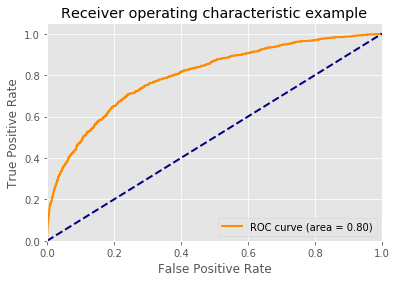

time: 359 ms


In [467]:
y_score

array([-1.5354067 , -1.08129551, -2.06383623, ..., -1.45741995,
        0.17838293, -2.30416815])

time: 1.97 ms


In [17]:
X, y = preprocessing(allFileRead(0))

time: 61.6 ms


In [251]:
X, y = preprocessing(allFileRead(0))
X= X.values
X=X[:, [0, 2]]

time: 72.3 ms


In [1]:
X=X[:, [0, 2]]

NameError: name 'X' is not defined

## cross validation

In [20]:
X, y, labels = preprocessing(allFileRead(0))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
clf = svm.SVC(kernel='linear', C=1)#.fit(X_train, y_train)
#clf.score(X_test, np.ravel(y_test))
scores = cross_val_score(clf, X, y, cv=5)
   

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-v

time: 44min 54s


In [133]:
from sklearn.model_selection import cross_val_score
classifier = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(classifier, X, y, cv=5)                                           

#The mean score and the 95% confidence interval of the score estimate are hence given by:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

KeyboardInterrupt: 

time: 8min 49s


In [21]:
scores

array([0.79908257, 0.79889807, 0.79338843, 0.77777778, 0.79981635])

time: 2.49 ms


In [34]:
#cv using logistic reg
from sklearn.model_selection import cross_val_score
X, y, labels = preprocessing(allFileRead(0))

classifier= LogisticRegression(class_weight="balanced")
scores = cross_val_score(classifier, X, y, cv=5)


#The mean score and the 95% confidence interval of the score estimate are hence given by:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.73 (+/- 0.04)
time: 2.62 s


Accuracy: 0.73 (+/- 0.04)
classification report:              precision    recall  f1-score   support

          0       0.87      0.75      0.81      4051
          1       0.48      0.68      0.56      1395

avg / total       0.77      0.73      0.74      5446
 model score: 0.7317297098788101 
 None AUC: 0.7848117505390501 
 Confusion matrix: 
 [[3041 1010]
 [ 451  944]]


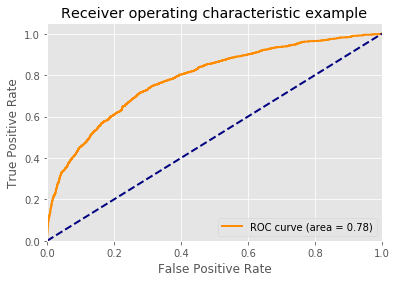

<module 'matplotlib.pyplot' from '/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/matplotlib/pyplot.py'>

time: 8.54 s


In [165]:
# #cv using logistic reg  ##correct
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, cross_validation
import sklearn.cross_validation
from sklearn.model_selection import cross_val_predict

X, y, labels = preprocessing(allFileRead(0))

# setup model
classifier= LogisticRegression(class_weight="balanced")

##initializing model NOTE NO MODEL.FIT WAS USED HERE IN CV METHOD, need to dig into more about why this works as it does.
#model_fit= classifier.fit(X, y)fit

# cross-validation scores
scores = cross_val_score(classifier, X, y, cv=5) #accuracy score across each cv
y_pred = cross_validation.cross_val_predict(classifier, X, y, cv=5)

##confusion matrix
confuse= confusion_matrix(y, y_pred) #which is the correct order?

##scoring model based on true positive prediction rate and AUC.
model_score= metrics.accuracy_score(y, y_pred)
y_score = cross_val_predict(classifier, X, y, cv=5, method='predict_proba')[:,1]
auc_score= roc_auc_score(y, y_score)

# """
# y_score : array, shape = [n_samples]
#     Target scores, can either be probability estimates of the positive class, confidence values, 
#     or non-thresholded measure of decisions (as returned by “decision_function” on some classifiers).
# """

print("classification report:", metrics.classification_report(y, y_pred),
      "model score: %s \n" %(model_score),
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)),
    "AUC: %s \n" % (roc_auc_score(y, y_score)),
     "Confusion matrix: \n %s" %(confuse))

model_roc(y, y_score)


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


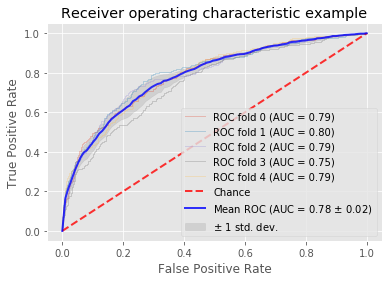

time: 2.91 s


In [45]:
###skl logistic regression auc with cv example (using manual implementation)

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp

cv = StratifiedKFold(n_splits=5)
# classifier = svm.SVC(kernel='linear', probability=True,
#                      random_state=random_state)
classifier= LogisticRegression(class_weight="balanced")

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X.as_matrix(), np.ravel(y)):
    probas_ = classifier.fit(X.as_matrix()[train], np.ravel(y)[train]).predict_proba(X.as_matrix()[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#### spline model (pyearth not working ><)

In [191]:
import numpy
from pyearth import Earth
from matplotlib import pyplot

import importlib.util
#spec = importlib.util.spec_from_file_location("pyearth.name", "/Users/geickelb1/Documents/GitHub/py-earth/pyearth/earth.py")⁨
#spec.loader.exec_module(foo)
#foo.MyClass()
#Fit an Earth model
model = Earth()
model.fit(X,y)

#Print the model
print(model.trace())
print(model.summary())

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()


Forward Pass
---------------------------------------------------------------
iter  parent  var  knot  mse       terms  gcv    rsq    grsq   
---------------------------------------------------------------
0     -       -    -     0.190538  1      0.191  0.000  0.000  
1     0       5    -1    0.174053  2      0.174  0.087  0.086  
2     0       15   -1    0.167064  3      0.167  0.123  0.122  
3     0       47   -1    0.163059  4      0.164  0.144  0.142  
4     0       26   -1    0.159829  5      0.160  0.161  0.158  
5     0       29   2769  0.157403  7      0.158  0.174  0.169  
6     0       8    -1    0.155871  8      0.157  0.182  0.177  
7     0       45   -1    0.154509  9      0.156  0.189  0.183  
8     0       37   -1    0.153247  10     0.155  0.196  0.189  
9     0       2    -1    0.152192  11     0.154  0.201  0.194  
10    0       12   4826  0.151205  13     0.153  0.206  0.198  
11    0       25   -1    0.150271  14     0.152  0.211  0.202  
12    0       57   -1    0.

/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


In [64]:
import sys
sys.path.append("/Users/geickelb1/Documents/GitHub/py-earth/pyearth")

time: 964 µs


In [69]:
configfile = '/Users/geickelb1/Documents/GitHub/py-earth/pyearth/earth.py'

import os
import sys

sys.path.append(os.path.dirname(os.path.expanduser(configfile)))

#import config
import earth

ImportError: attempted relative import with no known parent package

time: 15.6 ms


### variable visualization test (compressed)

## variable selection

try to select most used variables in random forest and logistic regression and choose ~20 most overapped, etc...



/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


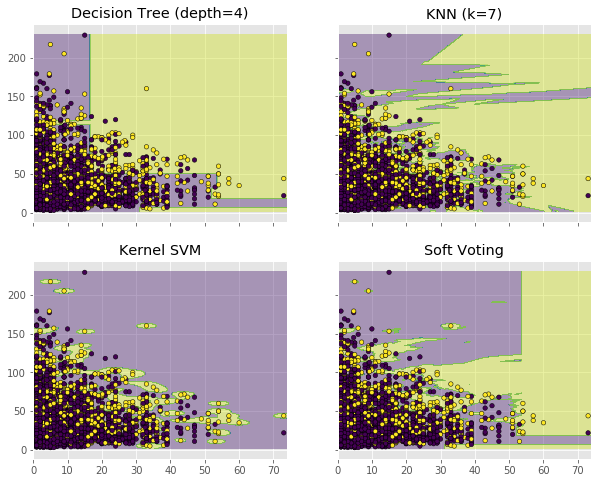

time: 3min 6s


In [571]:

X, y, y2 = preprocessing(allFileRead(0))
X= X.values
X=X[:, [0, 2]]
y3= pd.get_dummies(y2)["C_pos/A_full"].values

y=y3
# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(gamma=.1, kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2),
                                    ('svc', clf3)],
                        voting='soft', weights=[2, 1, 2])

clf1.fit(X, y)
clf2.fit(X, y)
clf3.fit(X, y)
eclf.fit(X, y)

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, eclf],
                        ['Decision Tree (depth=4)', 'KNN (k=7)', 'Kernel SVM', 'Soft Voting']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

ValueError: Number of features of the model must match the input. Model n_features is 61 and input n_features is 2 

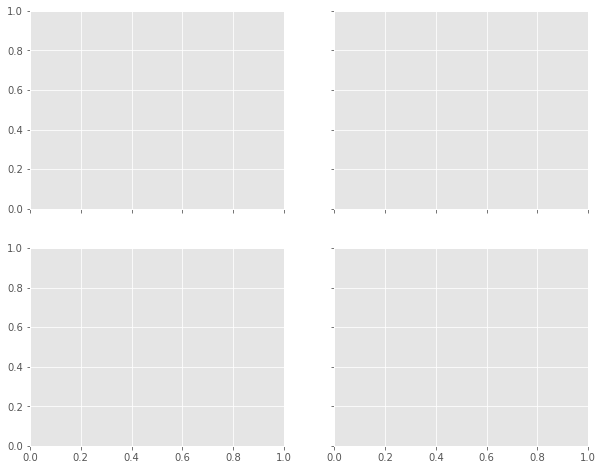

time: 25.8 s


In [577]:

X, y, y2 = preprocessing(allFileRead(0))
X= X.values
X=X#[:, [0, 2]]
y3= pd.get_dummies(y2)["C_pos/A_full"].values

y=y3
# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(gamma=.1, kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2),
                                    ('svc', clf3)],
                        voting='soft', weights=[2, 1, 2])

clf1.fit(X, y)
clf2.fit(X, y)
clf3.fit(X, y)
eclf.fit(X, y)

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, eclf],
                        ['Decision Tree (depth=4)', 'KNN (k=7)', 'Kernel SVM', 'Soft Voting']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

In [609]:
X, y = preprocessing(allFileRead(0))
X= X.values
X2=X[:, [0, 2]]
X[:, 0]

array([ 1., 11.,  1., ..., 28.,  2.,  1.])

time: 90.3 ms


In [584]:
X[:, [0, 2]] #this is column 0 and 2

array([[ 1., 24.],
       [11., 28.],
       [ 1., 16.],
       ...,
       [28., 45.],
       [ 2., 52.],
       [ 1.,  6.]])

time: 2.59 ms


In [592]:
X[:,2]

array([24., 28., 16., ..., 45., 52.,  6.])

time: 2.98 ms


In [576]:
for element in zip(product([0, 1], [0, 1]),[clf1, clf2, clf3, eclf],['Decision Tree (depth=4)', 'KNN (k=7)', 'Kernel SVM', 'Soft Voting']):
    print(element)

((0, 0), DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), 'Decision Tree (depth=4)')
((0, 1), KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform'), 'KNN (k=7)')
((1, 0), SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'Kernel SVM')
((1, 1), VotingClassifier(estimators=[('dt', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            mi

In [570]:
y3= pd.get_dummies(y2)["C_pos/A_full"].values

time: 2.31 ms


In [94]:
#update

time: 553 µs


# BACK FROM VACATION

above is the last stuff i did before vacation, todo 1/7/18: need to go through this code and:

* first need to evaluate the correlation matrix of variables pre and post imputation
* need to determine variables of most importance in models i build
* need to have a robust evaluation of model performance
* need to try cross validation

## evaluate the correlation matrix of variables pre and post imputation

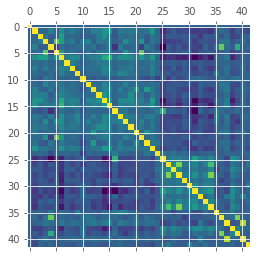

time: 183 ms


In [66]:
import matplotlib.pyplot as plt

plt.matshow(preImp.corr())

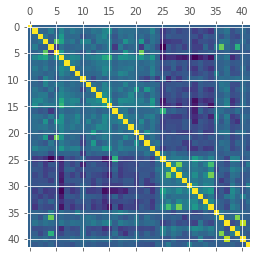

time: 193 ms


In [67]:
plt.matshow(allFileRead(0).corr())

In [69]:
list(allFileRead(0))

['icustay_id',
 'bandsNum',
 'bilirubin',
 'bun',
 'chloride',
 'creatinine',
 'daily_sofa',
 'dobutamine',
 'dopamine',
 'epinephrine',
 'first_admit_age',
 'glucose',
 'heartrate',
 'inr',
 'lactate',
 'norepinephrine',
 'pco2',
 'phenylephrine',
 'potassium',
 'ptt',
 'resprate',
 'rrt',
 'temperature',
 'vasopressin',
 'weight',
 'bicarbonate',
 'diasbp',
 'hemoglobin',
 'meanartpress',
 'mingcs',
 'pao2fio2Ratio',
 'ph',
 'platelet',
 'spo2',
 'sysbp',
 'maxCalcium',
 'maxSodium',
 'maxWBC',
 'minCalcium',
 'minSodium',
 'minWBC',
 'ethnicity',
 'gender',
 'leukocyte',
 'nitrite',
 'vent_recieved',
 'subject_id',
 'final_bin']

time: 42.2 ms


In [252]:
zero_train, zero_true= preprocessing(allFileRead(0))

time: 73 ms


In [253]:
zero_train['final_bin']= zero_true

time: 1.35 ms


In [254]:
zero_train.corr()['final_bin'].sort_values(ascending=False).head(10)

final_bin              1.000000
daily_sofa             0.294139
norepinephrine_True    0.273277
temperature            0.234445
heartrate              0.229896
resprate               0.209860
lactate                0.195415
leukocyte_pos          0.182554
bun                    0.168516
vasopressin_True       0.162623
Name: final_bin, dtype: float64

time: 36.9 ms


In [255]:
zero_train.corr()['final_bin'].sort_values(ascending=False).tail(10)

mingcs                     -0.166985
pao2fio2Ratio              -0.176573
diasbp                     -0.178968
spo2                       -0.179441
leukocyte_Neg/Not_tested   -0.182554
ph                         -0.186101
bicarbonate                -0.198054
meanartpress               -0.224079
sysbp                      -0.249949
norepinephrine_False       -0.273277
Name: final_bin, dtype: float64

time: 34.5 ms


In [256]:
preimp_train, preimp_true= preprocessing(preImp)
preimp_train['final_bin']= preimp_true
preimp_train.corr()['final_bin'].sort_values(ascending=False).head(10)

final_bin             1.000000
daily_sofa            0.278805
norepinephrine_1.0    0.267171
bands                 0.234639
temperature           0.232785
heartrate             0.227993
resprate              0.211399
lactate               0.201049
leukocyte_pos         0.185251
bun                   0.174393
Name: final_bin, dtype: float64

time: 119 ms


In [257]:
preimp_train.corr()['final_bin'].sort_values(ascending=False).tail(10)

pao2/fio2                  -0.173013
spo2                       -0.175086
ph                         -0.175139
mingcs                     -0.177748
diasbp                     -0.179659
leukocyte_Neg/Not_tested   -0.185251
bicarbonate                -0.188786
meanartpress               -0.224536
sysbp                      -0.248321
norepinephrine_0.0         -0.267171
Name: final_bin, dtype: float64

time: 69.5 ms


In [260]:
#feature standardization
zero_train, zero_true= preprocessing(allFileRead(0))
scaler = StandardScaler().fit(zero_train)
rescaledX = scaler.transform(zero_train)

preimp_train, preimp_true= preprocessing(preImp)
preimp_train['final_bin']= preimp_true
preimp_train.corr()['final_bin'].sort_values(ascending=False).head(10)

rescaledX_df=pd.DataFrame(rescaledX)
rescaledX_df.columns= list(zero_train)
rescaledX_df['final_bin']= zero_true

time: 77.1 ms


In [277]:
rescaledX_df=pd.DataFrame(rescaledX)
rescaledX_df.columns= list(zero_train)
rescaledX_df['final_bin']= zero_true
print(rescaledX_df.corr()['final_bin'].sort_values(ascending=False).head(10),
      rescaledX_df.corr()['final_bin'].sort_values(ascending=False).tail(10))


final_bin              1.000000
daily_sofa             0.294139
norepinephrine_True    0.273277
temperature            0.234445
heartrate              0.229896
resprate               0.209860
lactate                0.195415
leukocyte_pos          0.182554
bun                    0.168516
vasopressin_True       0.162623
Name: final_bin, dtype: float64 mingcs                     -0.166985
pao2fio2Ratio              -0.176573
diasbp                     -0.178968
spo2                       -0.179441
leukocyte_Neg/Not_tested   -0.182554
ph                         -0.186101
bicarbonate                -0.198054
meanartpress               -0.224079
sysbp                      -0.249949
norepinephrine_False       -0.273277
Name: final_bin, dtype: float64
time: 91.1 ms


model fit:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 
 model score: 0.7970987881013588 
 AUC: 0.7982608834138923 
 Confusion matrix: 
 [[3808  862]
 [ 243  533]]


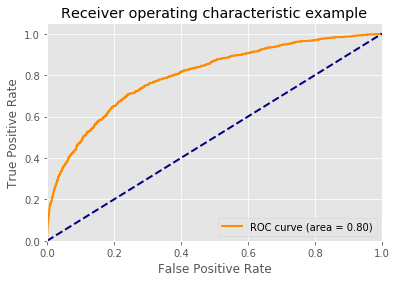

time: 363 ms


In [281]:
#feature standardization
zero_train, zero_true= preprocessing(allFileRead(0))
scaler = StandardScaler().fit(zero_train)
rescaledX = scaler.transform(zero_train)

preimp_train, preimp_true= preprocessing(preImp)
preimp_train['final_bin']= preimp_true
preimp_train.corr()['final_bin'].sort_values(ascending=False).head(10)

rescaledX_df=pd.DataFrame(rescaledX)
rescaledX_df.columns= list(zero_train)
modelAUC_preprocessed(rescaledX_df, zero_true)

In [289]:
allFileRead(0)['final_bin'].value_counts()

C_neg/A_partial    4051
C_pos/A_full       1395
Name: final_bin, dtype: int64

time: 47.6 ms


In [291]:
print(1395/(4051+1395))

0.25615130370914435
time: 1.41 ms


In [104]:
from sklearn.neighbors.kde import KernelDensity
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(zero_train[["final_bin","bandsNum"]])
kde.score_samples(zero_train[["final_bin","bandsNum"]])


array([-0.60289509, -3.99425044, -2.01761216, ..., -3.9635345 ,
       -0.83981395, -0.60289509])

time: 1.1 s


In [106]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(zero_train[["final_bin","bandsNum"]])
log_dens = kde.score_samples(X_plot)
ax[1, 1].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
ax[1, 1].text(-3.5, 0.31, "Gaussian Kernel Density")

ValueError: query data dimension must match training data dimension

time: 19.9 ms


In [105]:
X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]

time: 1.16 ms


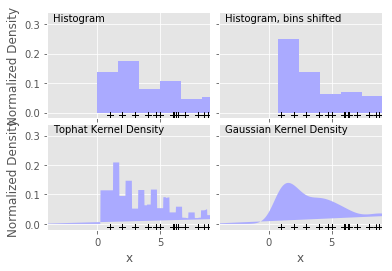

time: 686 ms


In [145]:
###modified example
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from distutils.version import LooseVersion
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

# `normed` is being deprecated in favor of `density` in histograms
if LooseVersion(matplotlib.__version__) >= '2.1':
    density_param = {'density': True}
else:
    density_param = {'normed': True}

#----------------------------------------------------------------------
# Plot the progression of histograms to kernels
X = zero_train[["bandsNum"]]
X=np.array(X)
X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]
bins = np.linspace(-5, 10, 10)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# histogram 1
ax[0, 0].hist(X[:, 0], bins=bins, fc='#AAAAFF', **density_param)
ax[0, 0].text(-3.5, 0.31, "Histogram")

# histogram 2
ax[0, 1].hist(X[:, 0], bins=bins + 0.75, fc='#AAAAFF', **density_param)
ax[0, 1].text(-3.5, 0.31, "Histogram, bins shifted")

# tophat KDE
kde = KernelDensity(kernel='tophat', bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 0].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
ax[1, 0].text(-3.5, 0.31, "Tophat Kernel Density")

# Gaussian KDE
kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 1].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
ax[1, 1].text(-3.5, 0.31, "Gaussian Kernel Density")

for axi in ax.ravel():
    axi.plot(X[:, 0], np.full(X.shape[0], -0.01), '+k')
    axi.set_xlim(-4, 9)
    axi.set_ylim(-0.02, 0.34)

for axi in ax[:, 0]:
    axi.set_ylabel('Normalized Density')

for axi in ax[1, :]:
    axi.set_xlabel('x')



In [155]:
np.array(zero_train["bandsNum"])

array([ 1., 11.,  1., ..., 28.,  2.,  1.])

time: 2.29 ms


In [194]:
###distribution of each variable
def dist_vis(df, variable):

    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    from distutils.version import LooseVersion
    from scipy.stats import norm
    from sklearn.neighbors import KernelDensity

    # `normed` is being deprecated in favor of `density` in histograms
    if LooseVersion(matplotlib.__version__) >= '2.1':
        density_param = {'density': True}
    else:
        density_param = {'normed': True}

    #----------------------------------------------------------------------
    # Plot the progression of histograms to kernels
    X=np.array(df[[variable]])
    #print(variable)
    X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]
    bins = np.linspace(-5, 10, 10)

    fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    fig.suptitle(variable, fontsize=16)
    #ax.title(variable, loc="top")

    # histogram 1
    ax[0, 0].hist(X[:, 0], bins=bins, fc='#AAAAFF', **density_param)
    ax[0, 0].text(-3.5, 0.31, "Histogram")

    # histogram 2
    ax[0, 1].hist(X[:, 0], bins=bins + 0.75, fc='#AAAAFF', **density_param)
    ax[0, 1].text(-3.5, 0.31, "Histogram, bins shifted")

    # tophat KDE
    kde = KernelDensity(kernel='tophat', bandwidth=0.75).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax[1, 0].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
    ax[1, 0].text(-3.5, 0.31, "Tophat Kernel Density")

    # Gaussian KDE
    kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax[1, 1].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
    ax[1, 1].text(-3.5, 0.31, "Gaussian Kernel Density")

    for axi in ax.ravel():
        axi.plot(X[:, 0], np.full(X.shape[0], -0.01), '+k')
        axi.set_xlim(-4, 9)
        axi.set_ylim(-0.02, 0.34)

    for axi in ax[:, 0]:
        axi.set_ylabel('Normalized Density')

    for axi in ax[1, :]:
        axi.set_xlabel('x')
    #ax.set_title(variable)
    #plt.title(variable)


time: 104 ms


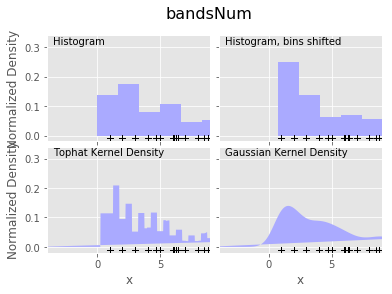

time: 610 ms


In [195]:
dist_vis(zero_train, "bandsNum")


/Users/geickelb1/anaconda/envs/rpy-env/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


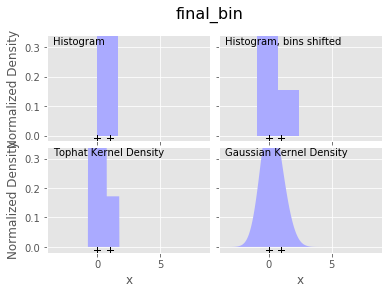

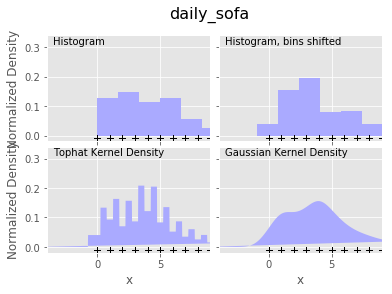

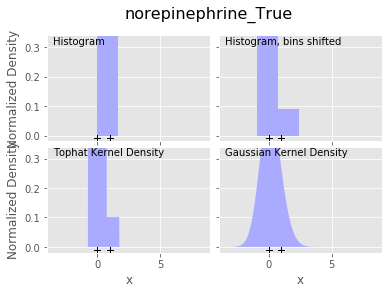

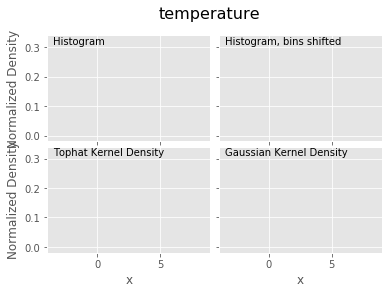

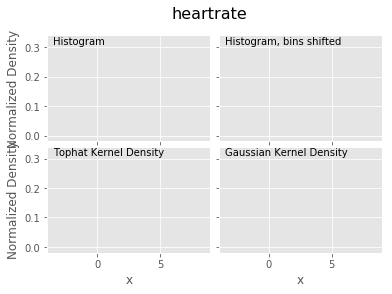

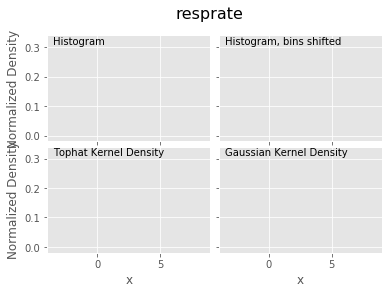

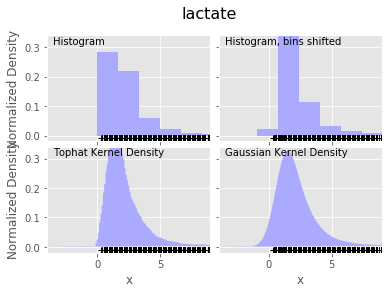

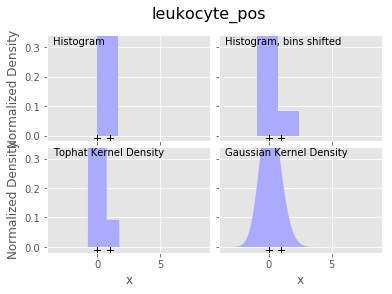

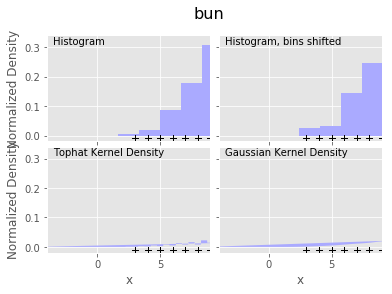

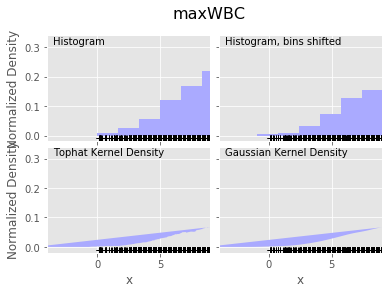

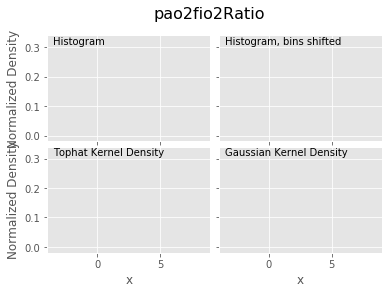

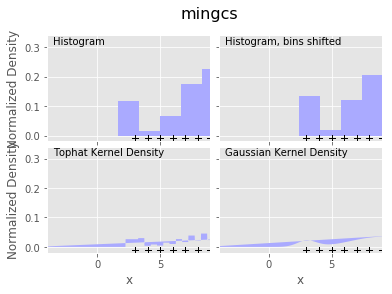

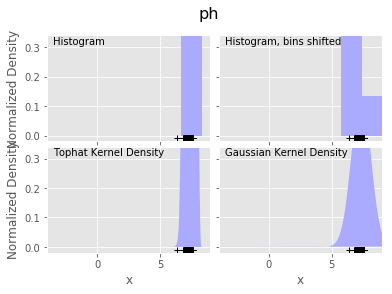

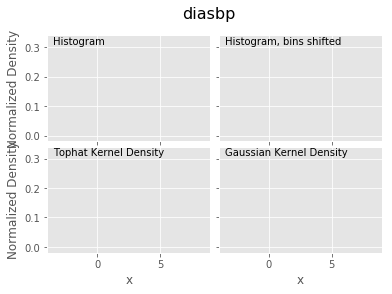

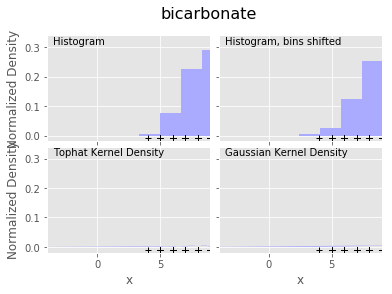

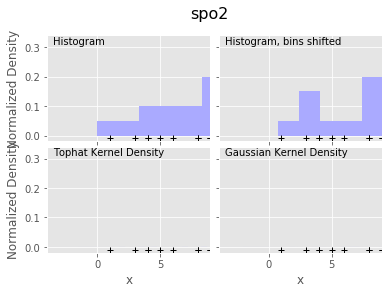

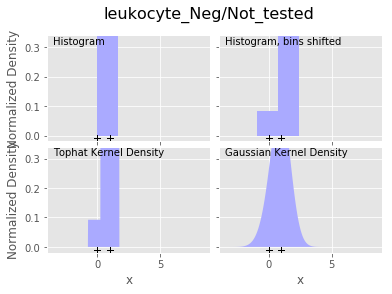

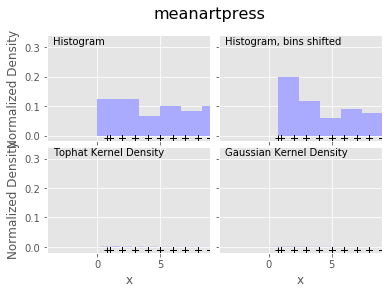

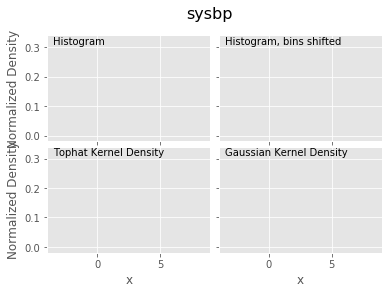

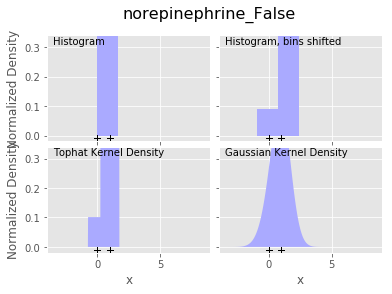

time: 9.84 s


In [196]:
#for element in 
most_corr= zero_train.corr()['final_bin'].sort_values(ascending=False).head(10).reset_index()['index']
lest_corr= zero_train.corr()['final_bin'].sort_values(ascending=False).tail(10).reset_index()['index']
most_corr= most_corr.append(lest_corr)
del(lest_corr)


for element in most_corr:
    dist_vis(zero_train, element)

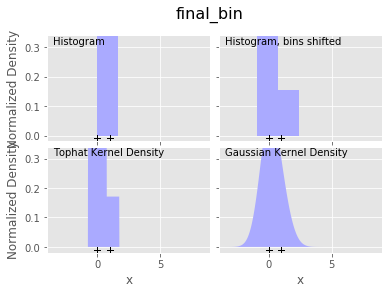

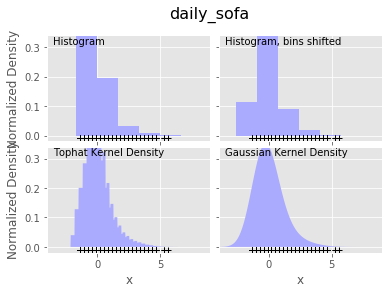

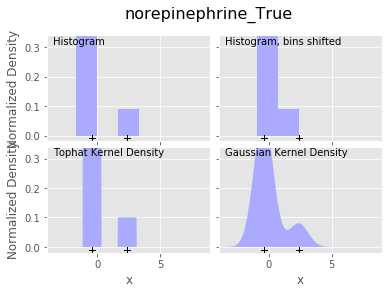

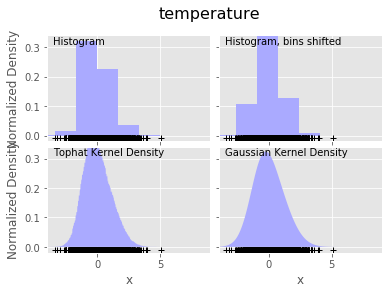

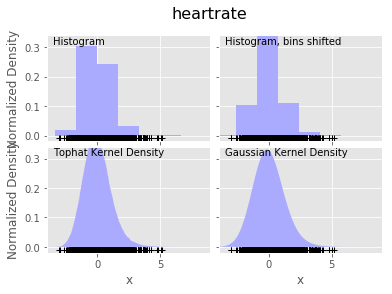

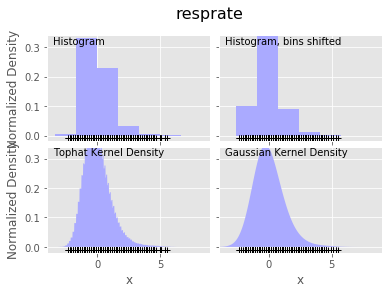

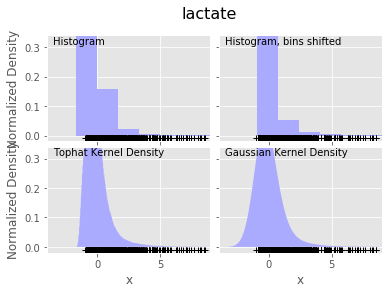

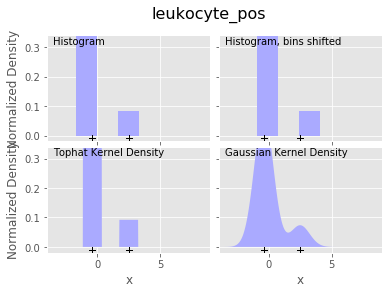

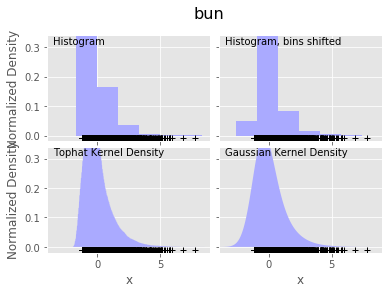

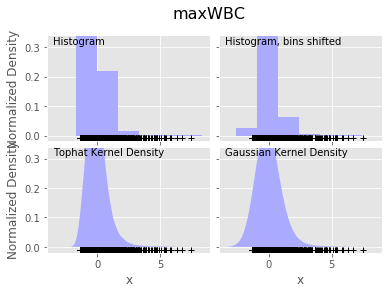

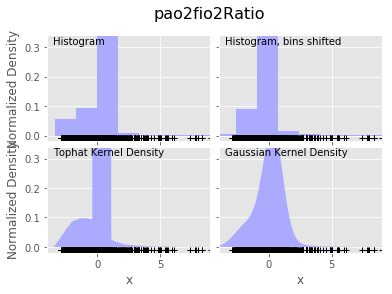

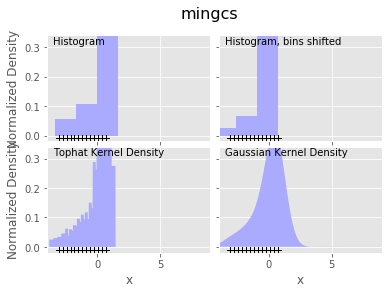

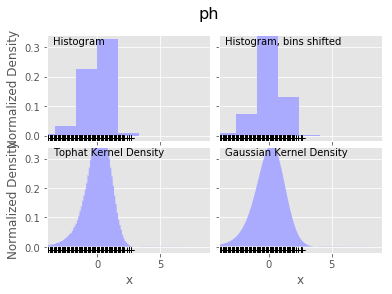

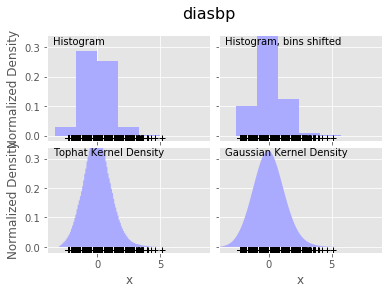

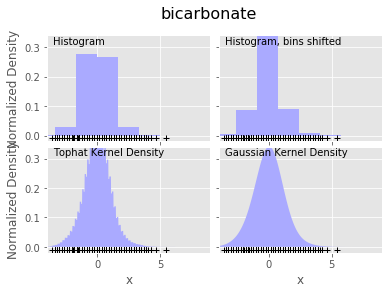

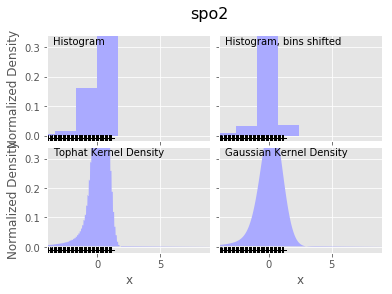

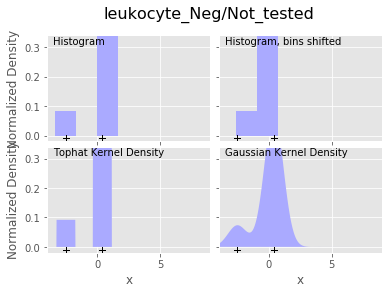

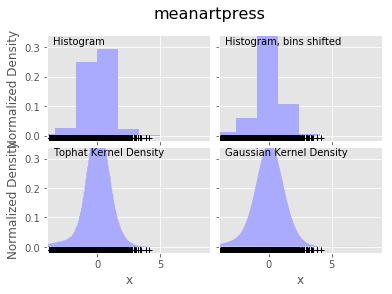

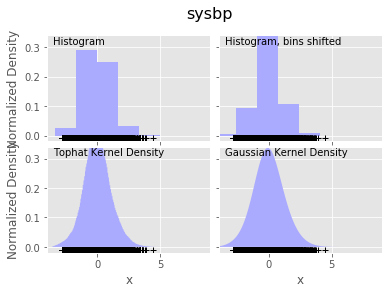

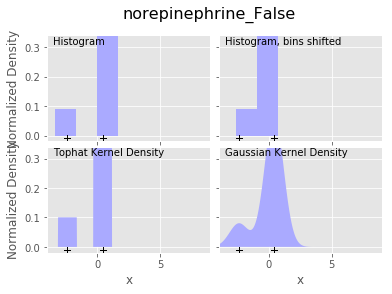

time: 13.2 s


In [286]:
rescaledX_df2=pd.DataFrame(rescaledX)
rescaledX_df2.columns= list(zero_train)
rescaledX_df2['final_bin']= zero_true

for element in most_corr:
    dist_vis(rescaledX_df2, element)

In [287]:
rescaledX_df2['norepinephrine_False']

0       0.420719
1       0.420719
2       0.420719
3       0.420719
4       0.420719
5       0.420719
6       0.420719
7       0.420719
8       0.420719
9       0.420719
10      0.420719
11      0.420719
12      0.420719
13      0.420719
14      0.420719
15     -2.376883
16      0.420719
17      0.420719
18      0.420719
19      0.420719
20      0.420719
21      0.420719
22      0.420719
23      0.420719
24      0.420719
25      0.420719
26      0.420719
27      0.420719
28      0.420719
29      0.420719
          ...   
5416   -2.376883
5417    0.420719
5418    0.420719
5419    0.420719
5420    0.420719
5421    0.420719
5422    0.420719
5423    0.420719
5424   -2.376883
5425    0.420719
5426    0.420719
5427    0.420719
5428    0.420719
5429   -2.376883
5430    0.420719
5431    0.420719
5432    0.420719
5433    0.420719
5434    0.420719
5435    0.420719
5436    0.420719
5437   -2.376883
5438    0.420719
5439    0.420719
5440   -2.376883
5441    0.420719
5442    0.420719
5443    0.4207

time: 4.04 ms


## need to determine variables of most importance in models i build


## need to have a robust evaluation of model performance


## need to try cross validation